<a href="https://colab.research.google.com/github/Srinathi117/Text-Classificiation-of-SMS-Messages-Spam-vs-Ham/blob/main/p1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install -q pandas nltk scikit-learn sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.3 MB/s eta 0:00:00


In [ ]:
%pip install -q matplotlib seaborn scikit-learn sentence-transformers

In [ ]:
# ====================== IMPORTS ======================
import pandas as pd
import nltk
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sentence_transformers import SentenceTransformer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [ ]:
# ====================== NLTK SETUP ======================
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# ====================== LOAD CSV FILE (COLAB FRIENDLY) ======================
from google.colab import files
uploaded = files.upload()

import io
df = pd.read_csv(io.BytesIO(uploaded['spam.csv']), encoding='latin1')

Saving spam.csv to spam.csv


In [ ]:
# ====================== DATA CLEANING ======================
df = df.rename(columns={'v1': 'label', 'v2': 'text'})
df = df[['label', 'text']]
df = df[df['text'].notna()]

In [ ]:
# ====================== SAMPLE DATASET FOR FASTER EXECUTION ======================
sample_size = 100
if sample_size is not None and len(df) > sample_size:
    df = df.sample(n=sample_size, random_state=42).reset_index(drop=True)

original_texts_for_clustering = df['text'].tolist()

In [ ]:
text_column = 'text'

print("\nFirst few rows of the dataset (after potential sampling):")
print(df.head())

print(f"\nNumber of non-null entries in '{text_column}': {df[text_column].notnull().sum()} / {len(df)}")

# Show sample text lengths
print("\nSample of text lengths:")
print(df[text_column].dropna().apply(len).head(10))

print("\nText length statistics:")
print(df[text_column].dropna().apply(len).describe())


First few rows of the dataset (after potential sampling):
  label                                               text
0   ham  Funny fact Nobody teaches volcanoes 2 erupt, t...
1   ham  I sent my scores to sophas and i had to do sec...
2  spam  We know someone who you know that fancies you....
3   ham  Only if you promise your getting out as SOON a...
4  spam  Congratulations ur awarded either å£500 of CD ...

Number of non-null entries in 'text': 100 / 100

Sample of text lengths:
0    151
1    221
2    101
3    124
4    150
5     42
6     41
7     38
8    109
9     26
Name: text, dtype: int64

Text length statistics:
count    100.000000
mean      82.830000
std       74.253056
min       11.000000
25%       35.000000
50%       58.000000
75%      116.250000
max      588.000000
Name: text, dtype: float64


In [ ]:
# ====================== TEXT PREPROCESSING ======================
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

print("\n=== Text Preprocessing Demonstration ===")
examples = df['text'].dropna().head(3).tolist()  # Replace text_column with actual column name

for i, text in enumerate(examples):
    print(f"\n--- Example {i+1} ---")
    print(f"Original: {text}")

    # Step 1: Lowercase
    lower = text.lower()
    print(f"Lowercased: {lower}")

    # Step 2: Tokenization
    tokens = word_tokenize(lower)
    print(f"Tokenized: {tokens}")

    # Step 3: Remove punctuation
    alpha_tokens = [t for t in tokens if t.isalpha()]
    print(f"Removed Punctuation: {alpha_tokens}")

    # Step 4: Remove stopwords
    no_stopwords = [t for t in alpha_tokens if t not in stop_words]
    print(f"Stopwords Removed: {no_stopwords}")

    # Step 5: Lemmatization
    lemmatized = [lemmatizer.lemmatize(t) for t in no_stopwords]
    print(f"Lemmatized: {lemmatized}")

    # Final cleaned sentence
    cleaned = ' '.join(lemmatized)
    print(f"Final Cleaned: {cleaned}")

# ====================== APPLY TO FULL (SAMPLED) DATASET ======================
def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha()]
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

df['cleaned_text'] = df['text'].apply(preprocess_text)




=== Text Preprocessing Demonstration ===

--- Example 1 ---
Original: Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teaches hw 2 choose a wife Natural disasters just happens
Lowercased: funny fact nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teaches hw 2 choose a wife natural disasters just happens
Tokenized: ['funny', 'fact', 'nobody', 'teaches', 'volcanoes', '2', 'erupt', ',', 'tsunamis', '2', 'arise', ',', 'hurricanes', '2', 'sway', 'aroundn', 'no', '1', 'teaches', 'hw', '2', 'choose', 'a', 'wife', 'natural', 'disasters', 'just', 'happens']
Removed Punctuation: ['funny', 'fact', 'nobody', 'teaches', 'volcanoes', 'erupt', 'tsunamis', 'arise', 'hurricanes', 'sway', 'aroundn', 'no', 'teaches', 'hw', 'choose', 'a', 'wife', 'natural', 'disasters', 'just', 'happens']
Stopwords Removed: ['funny', 'fact', 'nobody', 'teaches', 'volcanoes', 'erupt', 'tsunamis', 'arise', 'hurricanes', 'sway', 'aroundn', 'tea

In [ ]:
# Limit to first 100 rows
limited_text = df['cleaned_text'].head(100)

# ====================== BOW REPRESENTATION ======================
print("\n=== Bag of Words (BoW) Representation ===")

# Initialize CountVectorizer
bow_vectorizer = CountVectorizer()

# Fit and transform the first 100 cleaned texts
bow_matrix = bow_vectorizer.fit_transform(limited_text)

# Convert to DataFrame
bow_df = pd.DataFrame(bow_matrix.toarray(), columns=bow_vectorizer.get_feature_names_out())

# Display shape and sample
print(f"BoW matrix shape: {bow_matrix.shape}")
print("\nSample BoW features (first 5 rows):")
print(bow_df.head())

# ====================== TF-IDF REPRESENTATION ======================
print("\n=== TF-IDF Representation ===")

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the first 100 cleaned texts
tfidf_matrix = tfidf_vectorizer.fit_transform(limited_text)

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Show shape and first few rows
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
print("\nSample TF-IDF features (first 5 rows):")
print(tfidf_df.head())



=== Bag of Words (BoW) Representation ===
BoW matrix shape: (100, 563)

Sample BoW features (first 5 rows):
   abt  advance  aft  agalla  aiyar  alaipayuthe  allalo  alle  alone  \
0    0        0    0       0      0            0       0     0      0   
1    0        0    0       0      0            0       0     0      0   
2    0        0    0       0      0            0       0     0      0   
3    0        0    0       0      0            0       0     0      0   
4    0        0    0       0      0            0       0     0      0   

   already  ...  xx  yarasu  yaxxx  yay  yeah  year  yes  yet  yup  ìï  
0        0  ...   0       0      0    0     0     0    0    0    0   0  
1        0  ...   0       0      0    0     0     0    0    0    0   0  
2        0  ...   0       0      0    0     0     0    0    0    0   0  
3        0  ...   0       0      0    0     0     0    0    0    0   0  
4        0  ...   0       0      0    0     0     0    0    0    0   0  

[5 rows x 563


=== Bag of Words (BoW) Representation ===
BoW matrix shape: (100, 563)

=== TF-IDF Representation ===
TF-IDF matrix shape: (100, 563)


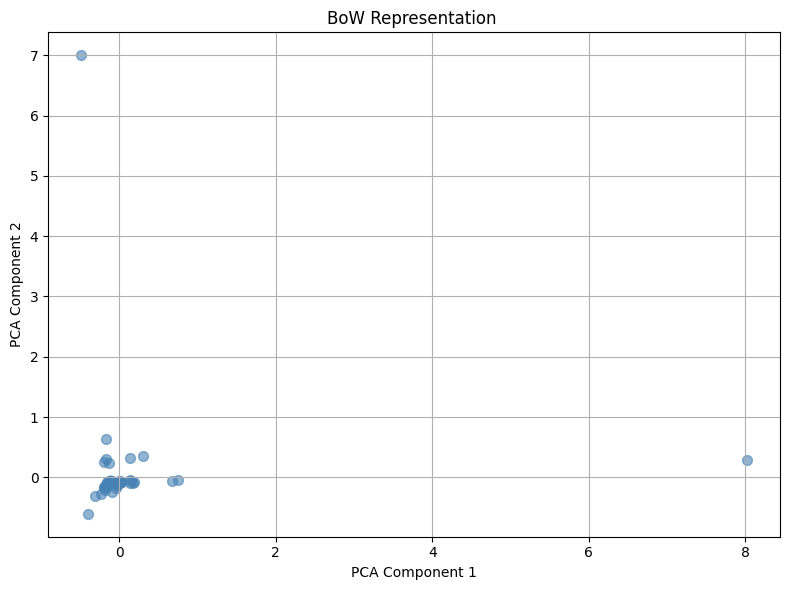

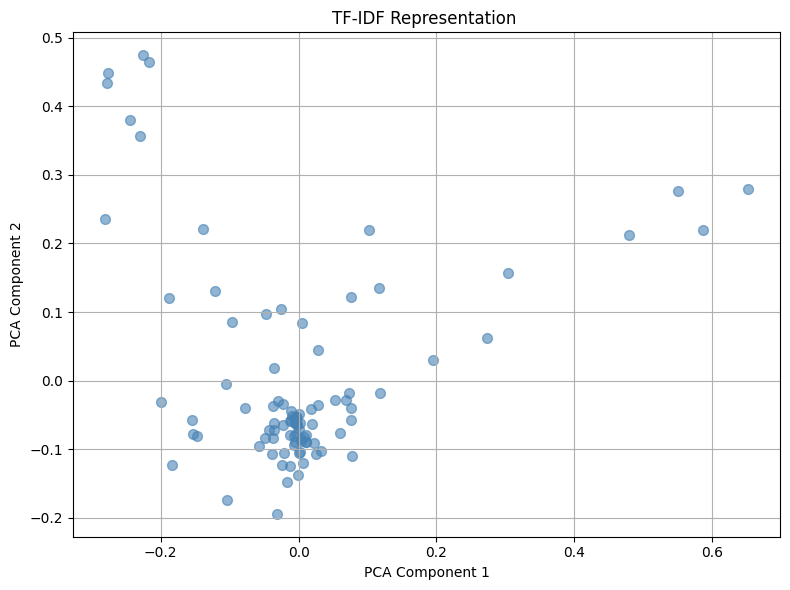

In [ ]:
# Use only first 100 rows
sampled_text = df['cleaned_text'].head(100)

print("\n=== Bag of Words (BoW) Representation ===")
bow_vectorizer = CountVectorizer()
bow_matrix = bow_vectorizer.fit_transform(sampled_text)
print("BoW matrix shape:", bow_matrix.shape)

print("\n=== TF-IDF Representation ===")
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(sampled_text)
print("TF-IDF matrix shape:", tfidf_matrix.shape)

# Dimensionality Reduction (SVD → PCA)
n_components_dim_reduction = 100

# Ensure SVD components are not more than available features - 1
svd_bow = TruncatedSVD(n_components=min(n_components_dim_reduction, bow_matrix.shape[1]-1), random_state=42)
bow_matrix_reduced = svd_bow.fit_transform(bow_matrix)

svd_tfidf = TruncatedSVD(n_components=min(n_components_dim_reduction, tfidf_matrix.shape[1]-1), random_state=42)
tfidf_matrix_reduced = svd_tfidf.fit_transform(tfidf_matrix)

# Visualization function
def visualize_2d_projection(X, title="2D Projection"):
    pca = PCA(n_components=2, random_state=42)
    reduced_2d = pca.fit_transform(X)
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_2d[:, 0], reduced_2d[:, 1], alpha=0.6, s=50, c='steelblue')
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Visualize BoW and TF-IDF
visualize_2d_projection(bow_matrix_reduced, title="BoW Representation ")
visualize_2d_projection(tfidf_matrix_reduced, title="TF-IDF Representation ")

In [ ]:
# ====================== SENTENCE EMBEDDING MODELS ======================
print("\n=== Generating Sentence Embeddings ===")

# Load sentence embedding models
embedding_models = {
    "all-MiniLM-L6-v2": SentenceTransformer("all-MiniLM-L6-v2"),
    # Uncomment these if you want to include them (slower)
    "paraphrase-MiniLM-L6-v2": SentenceTransformer("paraphrase-MiniLM-L6-v2"),
    "paraphrase-distilroberta-base-v1": SentenceTransformer("paraphrase-distilroberta-base-v1")
}

# Take only the first 100 cleaned texts
texts_for_embedding = df['cleaned_text'].head(100).tolist()

# Generate embeddings
sentence_embeddings = {}

for model_name, model in embedding_models.items():
    print(f"\nEmbedding with model: {model_name}")
    embeddings = model.encode(texts_for_embedding, show_progress_bar=True)
    sentence_embeddings[model_name] = embeddings
    print(f"Shape of embeddings ({model_name}): {embeddings.shape}")


=== Generating Sentence Embeddings ===


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


Embedding with model: all-MiniLM-L6-v2


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Shape of embeddings (all-MiniLM-L6-v2): (100, 384)

Embedding with model: paraphrase-MiniLM-L6-v2


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Shape of embeddings (paraphrase-MiniLM-L6-v2): (100, 384)

Embedding with model: paraphrase-distilroberta-base-v1


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Shape of embeddings (paraphrase-distilroberta-base-v1): (100, 768)


*all-MiniLM-L6-v2: Multiple sentence similarity tasks
                 - 384 vectors
                 - Example: A man is playing guitar &  Someone performs Music -> very close vectors.

*paraphrase-MiniLM-L6-v2: Say the same things in different words - 384 vectors
                        -Example: He went Home & He returned to his house
                        -> highly similar vector

*paraphrase-distilroberta-base-v1: Deep understanding of sentence Meaning - 768 vectors

In [ ]:
# ====================== VISUALIZATION FUNCTION ======================
def visualize_clusters(X, labels, title):
    try:
        X_input = X.toarray() if hasattr(X, 'toarray') else X
        pca = PCA(n_components=2, random_state=42)
        reduced_X = pca.fit_transform(X_input)

        plt.figure(figsize=(8, 6))
        unique_labels = np.unique(labels)
        palette = sns.color_palette("tab10", len(unique_labels))

        for label in unique_labels:
            if label == -1:
                plt.scatter(reduced_X[labels == label, 0], reduced_X[labels == label, 1],
                            c='gray', label="Noise", s=40, alpha=0.5)
                continue

            plt.scatter(reduced_X[labels == label, 0], reduced_X[labels == label, 1],
                        label=f"Cluster {label}", s=50, alpha=0.7, color=palette[label % len(palette)])

        plt.title(f"Cluster Visualization: {title}")
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.legend()
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"Visualization failed for {title}: {e}")

# ====================== CLUSTERING + INTERPRETATION FUNCTION ======================
def cluster_and_interpret(X, name, original_texts):
    # Limit to first 100 rows
    X = X[:100]
    original_texts = original_texts[:100]

    clustering_algos = {
        "KMeans": KMeans,
        "Agglomerative": AgglomerativeClustering,
        "GMM": GaussianMixture,
        "Spectral": SpectralClustering,
        "DBSCAN": DBSCAN
    }

    cluster_sizes = [3, 5, 7]

    print(f"\n--- Clustering for {name} ---")
    for algo_name, algo in clustering_algos.items():
        for k in cluster_sizes:
            try:
                labels = None
                X_input = X.toarray() if hasattr(X, 'toarray') else X

                if algo_name == "DBSCAN":
                    model = algo(eps=0.5, min_samples=max(5, int(X_input.shape[1] * 0.1)))
                    labels = model.fit_predict(X_input)
                elif algo_name == "GMM":
                    model = algo(n_components=k, random_state=42)
                    labels = model.fit(X_input).predict(X_input)
                elif algo_name == "Spectral":
                    model = algo(n_clusters=k, random_state=42, affinity='nearest_neighbors', n_neighbors=10)
                    labels = model.fit_predict(X_input)
                else:
                    model = algo(n_clusters=k, random_state=42) if algo_name == "KMeans" else algo(n_clusters=k)
                    labels = model.fit_predict(X_input)

                print(f"\n== {algo_name} | {name} | Clusters = {k} ==")
                for cluster_id in np.unique(labels):
                    if cluster_id == -1:
                        continue  # Skip noise
                    indices = np.where(labels == cluster_id)[0][:5]
                    print(f"\n-- Cluster {cluster_id} --")
                    for i in indices:
                        print(f"> {original_texts[i][:100]}...")

                visualize_clusters(X_input, labels, f"{algo_name} | {name} | k={k}")

            except Exception as e:
                print(f"Error in {algo_name} | {name} | k={k}: {e}")


--- Clustering for BoW_Cleaned ---

== KMeans | BoW_Cleaned | Clusters = 3 ==

-- Cluster 0 --
> Hey mate. Spoke to the mag people. WeÛ÷re on.  the is deliver by the end of the month. Deliver on t...

-- Cluster 1 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150...
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...
> I'll text carlos and let you know, hang on...

-- Cluster 2 --
> Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me...


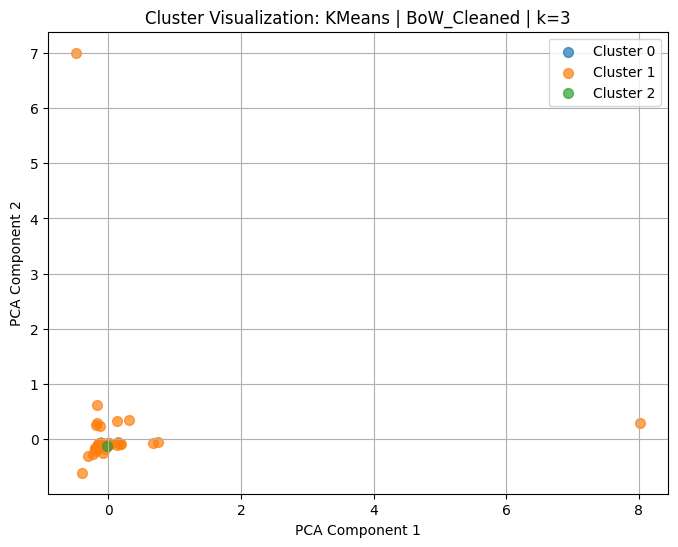


== KMeans | BoW_Cleaned | Clusters = 5 ==

-- Cluster 0 --
> Hey mate. Spoke to the mag people. WeÛ÷re on.  the is deliver by the end of the month. Deliver on t...

-- Cluster 1 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150...
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...
> I'll text carlos and let you know, hang on...

-- Cluster 2 --
> Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me...

-- Cluster 3 --
> Buy Space Invaders 4 a chance 2 win orig Arcade Game console. Press 0 for Games Arcade (std WAP char...

-- Cluster 4 --
> Sad story of a Man - Last week was my b'day. My Wife did'nt wish me. My Parents 

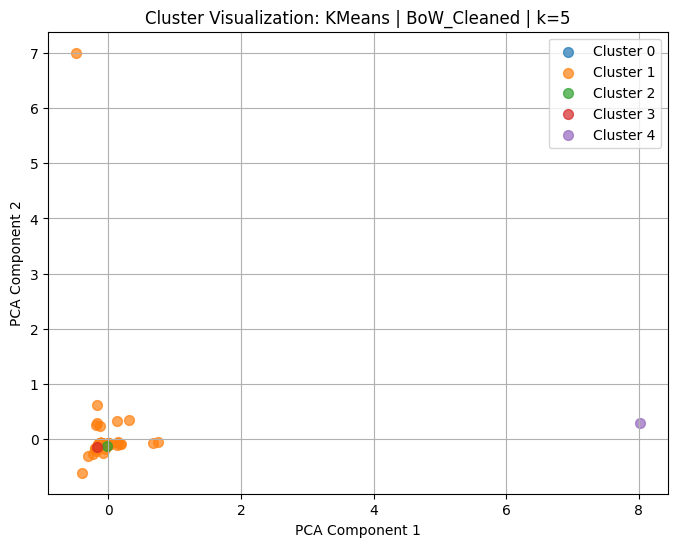


== KMeans | BoW_Cleaned | Clusters = 7 ==

-- Cluster 0 --
> Hey mate. Spoke to the mag people. WeÛ÷re on.  the is deliver by the end of the month. Deliver on t...

-- Cluster 1 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150...
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...
> I'll text carlos and let you know, hang on...

-- Cluster 2 --
> Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me...

-- Cluster 3 --
> Buy Space Invaders 4 a chance 2 win orig Arcade Game console. Press 0 for Games Arcade (std WAP char...

-- Cluster 4 --
> Sad story of a Man - Last week was my b'day. My Wife did'nt wish me. My Parents 

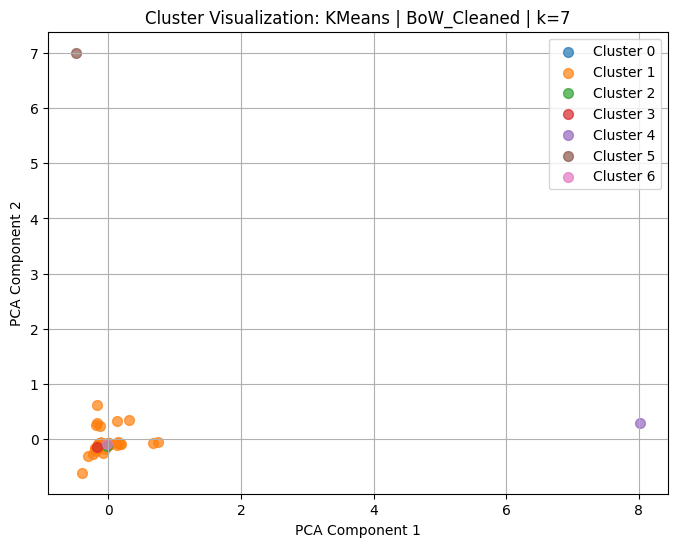


== Agglomerative | BoW_Cleaned | Clusters = 3 ==

-- Cluster 0 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150...
> Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me...
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...

-- Cluster 1 --
> Sad story of a Man - Last week was my b'day. My Wife did'nt wish me. My Parents forgot n so did my K...

-- Cluster 2 --
> Boy; I love u Grl: Hogolo Boy: gold chain kodstini Grl: Agalla Boy: necklace madstini Grl: agalla Bo...


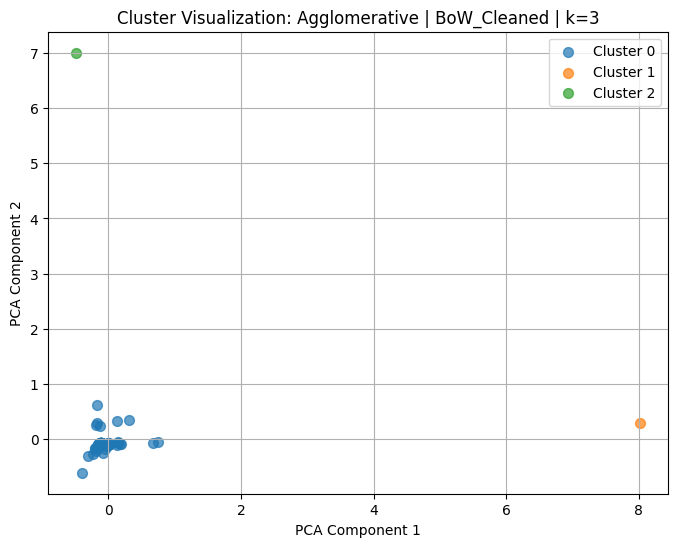


== Agglomerative | BoW_Cleaned | Clusters = 5 ==

-- Cluster 0 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150...
> Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me...
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...

-- Cluster 1 --
> Sad story of a Man - Last week was my b'day. My Wife did'nt wish me. My Parents forgot n so did my K...

-- Cluster 2 --
> Boy; I love u Grl: Hogolo Boy: gold chain kodstini Grl: Agalla Boy: necklace madstini Grl: agalla Bo...

-- Cluster 3 --
> see, i knew giving you a break a few times woul lead to you always wanting to miss curfew. I was gon...

-- Cluster 4 --
> There's someone

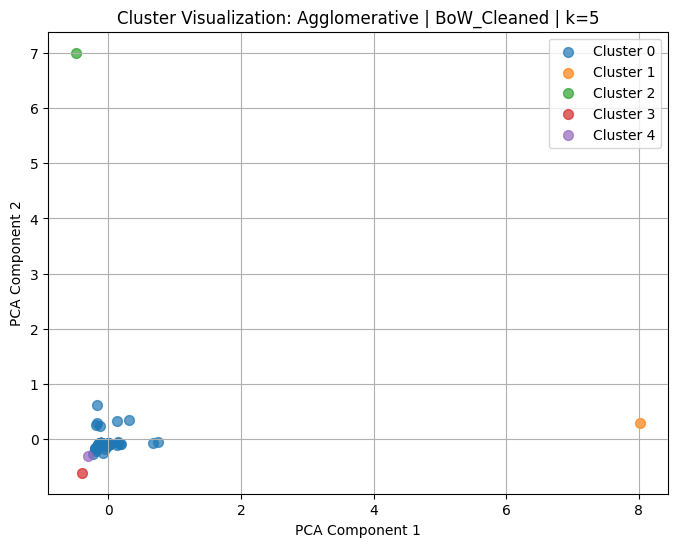


== Agglomerative | BoW_Cleaned | Clusters = 7 ==

-- Cluster 0 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150...
> Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me...
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...
> I'll text carlos and let you know, hang on...

-- Cluster 1 --
> Sad story of a Man - Last week was my b'day. My Wife did'nt wish me. My Parents forgot n so did my K...

-- Cluster 2 --
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> Honeybee Said: *I'm d Sweetest in d World* God Laughed &amp; Said: *Wait,U Havnt Met d Person Readin...

-- Cluster 3 --
> see, i knew giving you a break a few times woul lead to you always wanting to miss curfew.

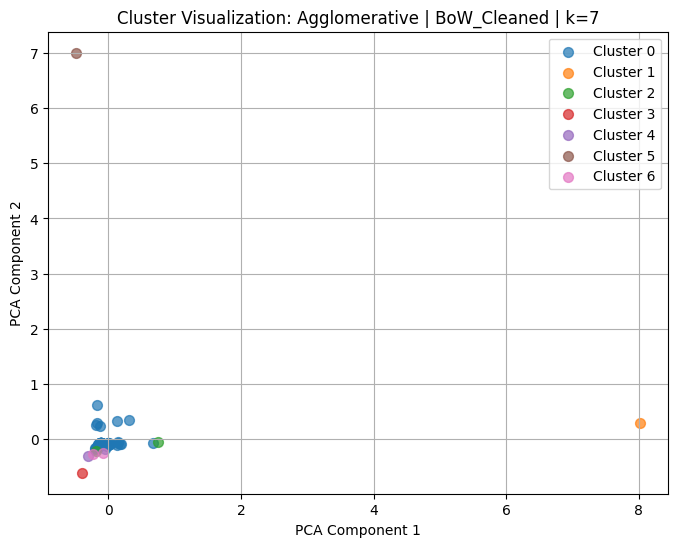


== GMM | BoW_Cleaned | Clusters = 3 ==

-- Cluster 0 --
> Hey mate. Spoke to the mag people. WeÛ÷re on.  the is deliver by the end of the month. Deliver on t...

-- Cluster 1 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150...
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...
> I'll text carlos and let you know, hang on...

-- Cluster 2 --
> Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me...


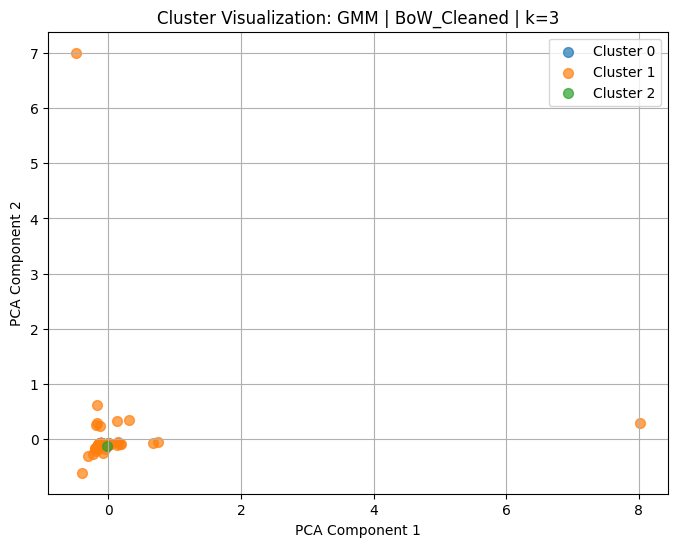


== GMM | BoW_Cleaned | Clusters = 5 ==

-- Cluster 0 --
> Hey mate. Spoke to the mag people. WeÛ÷re on.  the is deliver by the end of the month. Deliver on t...

-- Cluster 1 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150...
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...
> I'll text carlos and let you know, hang on...

-- Cluster 2 --
> Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me...

-- Cluster 3 --
> Buy Space Invaders 4 a chance 2 win orig Arcade Game console. Press 0 for Games Arcade (std WAP char...

-- Cluster 4 --
> Sad story of a Man - Last week was my b'day. My Wife did'nt wish me. My Parents for

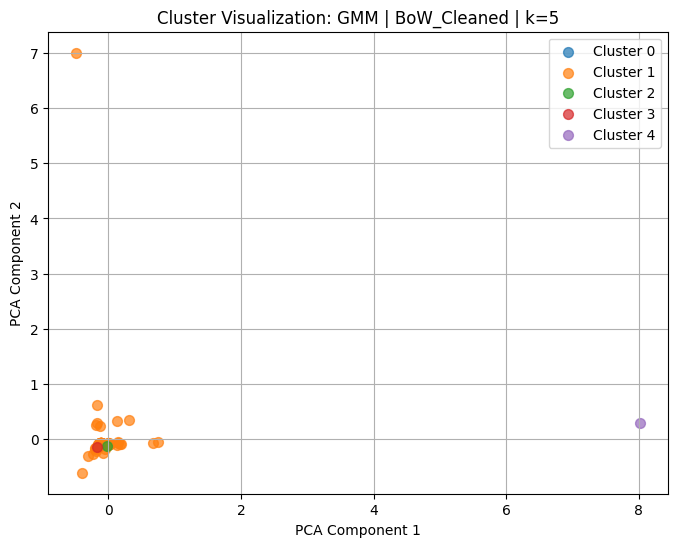


== GMM | BoW_Cleaned | Clusters = 7 ==

-- Cluster 0 --
> Hey mate. Spoke to the mag people. WeÛ÷re on.  the is deliver by the end of the month. Deliver on t...

-- Cluster 1 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150...
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...
> I'll text carlos and let you know, hang on...

-- Cluster 2 --
> Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me...

-- Cluster 3 --
> Buy Space Invaders 4 a chance 2 win orig Arcade Game console. Press 0 for Games Arcade (std WAP char...

-- Cluster 4 --
> Sad story of a Man - Last week was my b'day. My Wife did'nt wish me. My Parents for

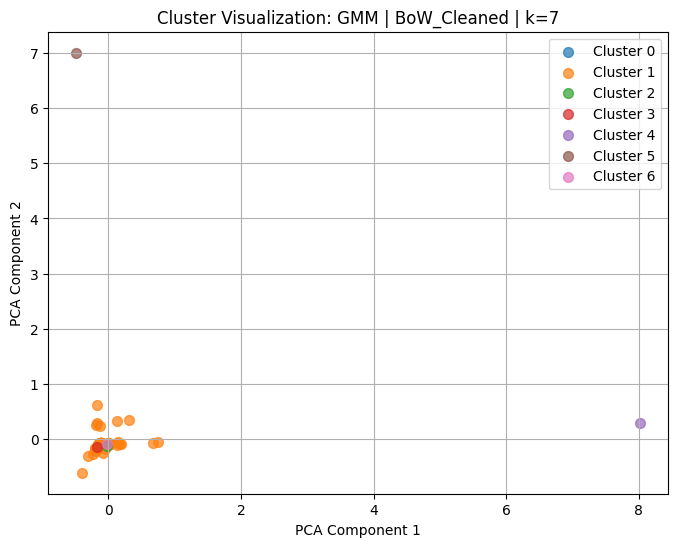


== Spectral | BoW_Cleaned | Clusters = 3 ==

-- Cluster 0 --
> Gud gud..k, chikku tke care.. sleep well gud nyt...
> I'll reach in ard 20 mins ok......
> Ok.. ÌÏ finishing soon?...
> Daddy will take good care of you :)...
> Ur HMV Quiz cash-balance is currently å£500 - to maximize ur cash-in now send HMV1 to 86688 only 150...

-- Cluster 1 --
> Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me...
> Call me when u finish then i come n pick u....
> What's up. Do you want me to come online?...
> URGENT! Your mobile was awarded a å£1,500 Bonus Caller Prize on 27/6/03. Our final attempt 2 contact...
> K, if u bored up just come to my home.....

-- Cluster 2 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> We know someone who you know that fancies you. Call 09058097218 to fin

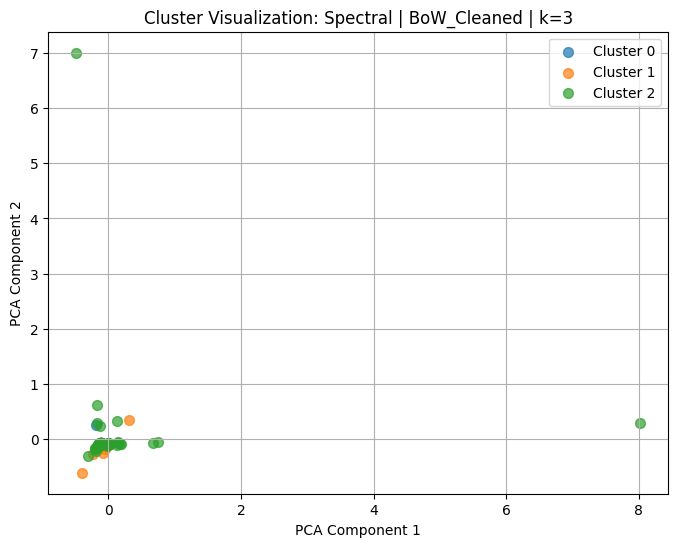


== Spectral | BoW_Cleaned | Clusters = 5 ==

-- Cluster 0 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...
> K.i did't see you.:)k:)where are you now?...
> No message..no responce..what happend?...

-- Cluster 1 --
> We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150...
> Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me...
> I'll text carlos and let you know, hang on...
> Free tones Hope you enjoyed your new content. text stop to 61610 to unsubscribe. help:08712400602450...
> Hi I'm sue. I am 20 years old and work as a lapdancer. I love sex. Text me live - I'm i my bedroom n...

-- Cluster 2 --
> Gud gud..k, chikku tk

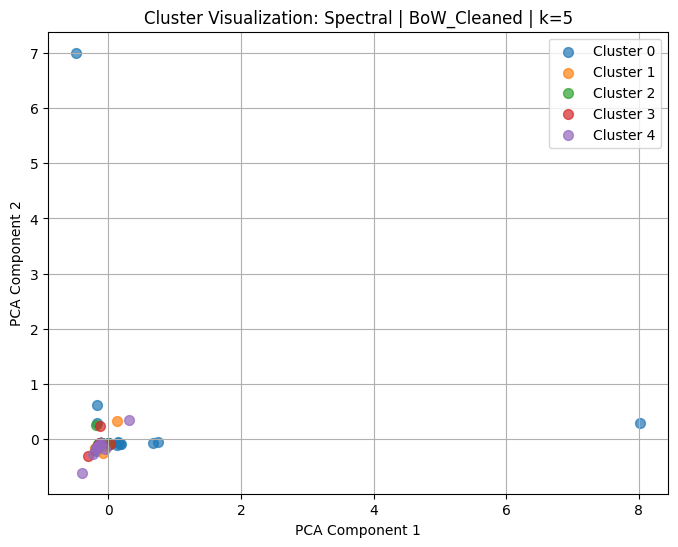


== Spectral | BoW_Cleaned | Clusters = 7 ==

-- Cluster 0 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...
> K.i did't see you.:)k:)where are you now?...
> No message..no responce..what happend?...

-- Cluster 1 --
> Call me when u finish then i come n pick u....
> URGENT! Your mobile was awarded a å£1,500 Bonus Caller Prize on 27/6/03. Our final attempt 2 contact...
> Can Ì_ call me at 10:10 to make sure dat i've woken up......
> This is the 2nd time we have tried 2 contact u. U have won the å£750 Pound prize. 2 claim is easy, c...
> No it was cancelled yeah baby! Well that sounds important so i understand my darlin give me a ring l...

-- Cluster 2 --
> Gud gud..k, chikku tke care.. sleep well gud nyt...
> I'll reac

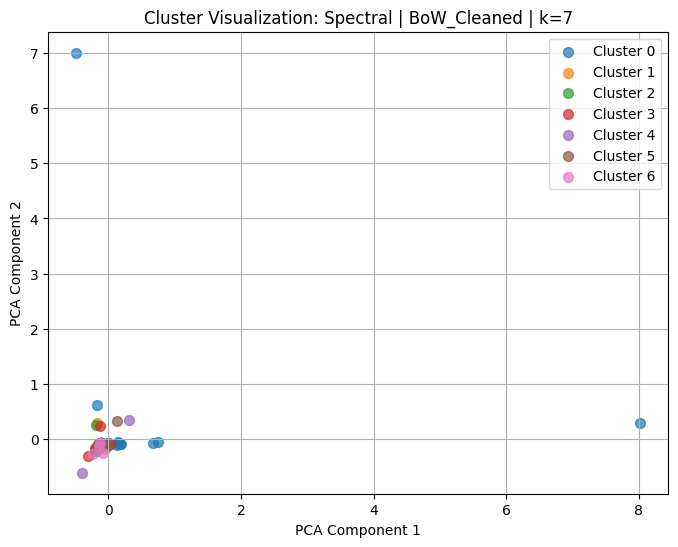


== DBSCAN | BoW_Cleaned | Clusters = 3 ==


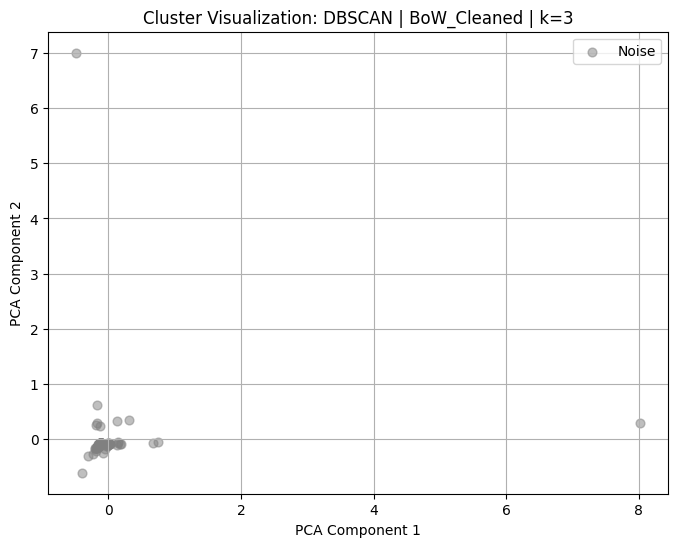


== DBSCAN | BoW_Cleaned | Clusters = 5 ==


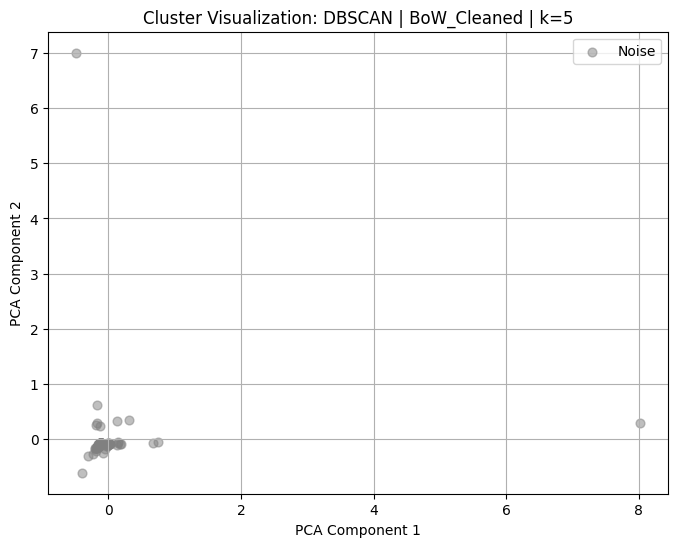


== DBSCAN | BoW_Cleaned | Clusters = 7 ==


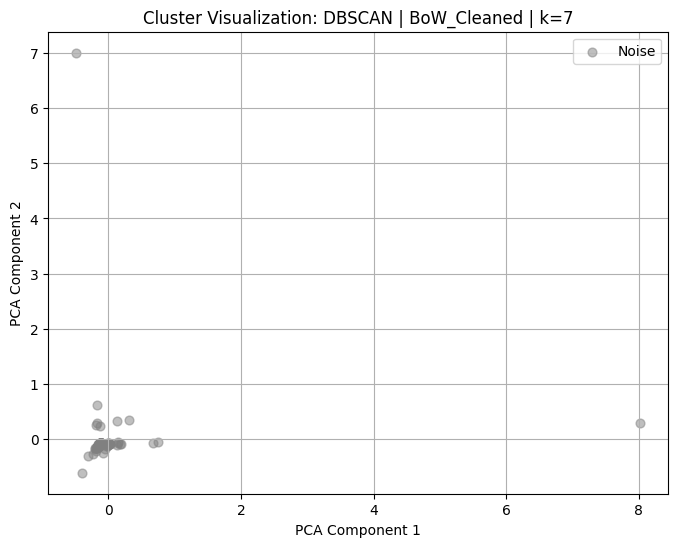


--- Clustering for TFIDF_Cleaned ---

== KMeans | TFIDF_Cleaned | Clusters = 3 ==

-- Cluster 0 --
> Dear how is chechi. Did you talk to her...
> No it was cancelled yeah baby! Well that sounds important so i understand my darlin give me a ring l...
> Done it but internet connection v slow and canÛ÷t send it. Will try again later or first thing tomo...
> I can't speak, bcaz mobile have problem. I can listen you but you cann't listen my voice. So i calls...
> Hey mate. Spoke to the mag people. WeÛ÷re on.  the is deliver by the end of the month. Deliver on t...

-- Cluster 1 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...
> K.i did't see you.:)k:)where are you now?...
> No message..no responce..what happend?...

-- C

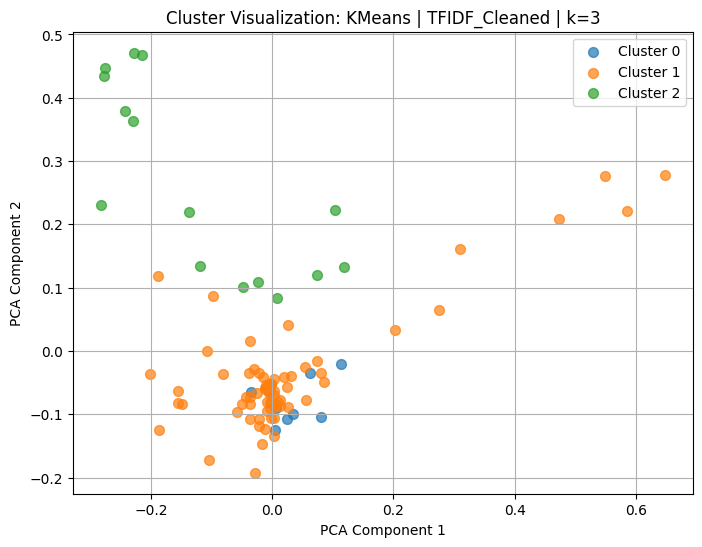


== KMeans | TFIDF_Cleaned | Clusters = 5 ==

-- Cluster 0 --
> Dear how is chechi. Did you talk to her...
> No it was cancelled yeah baby! Well that sounds important so i understand my darlin give me a ring l...
> Done it but internet connection v slow and canÛ÷t send it. Will try again later or first thing tomo...
> I can't speak, bcaz mobile have problem. I can listen you but you cann't listen my voice. So i calls...
> Hey mate. Spoke to the mag people. WeÛ÷re on.  the is deliver by the end of the month. Deliver on t...

-- Cluster 1 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...
> K.i did't see you.:)k:)where are you now?...
> No message..no responce..what happend?...

-- Cluster 2 --
> We know someone who you 

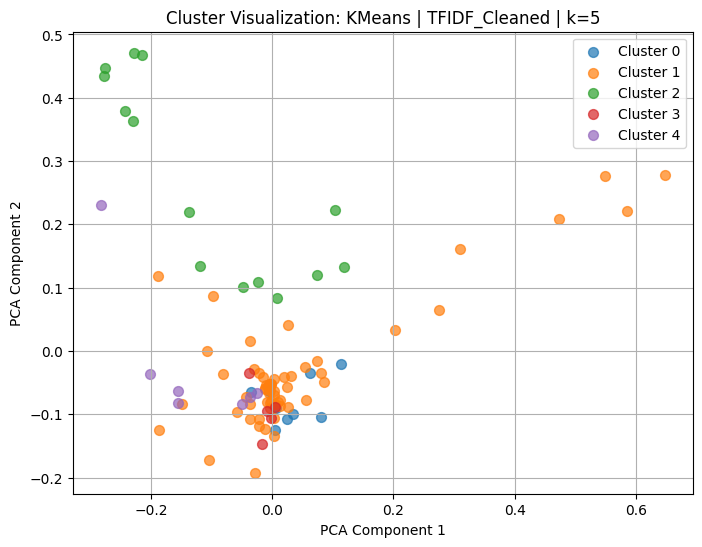


== KMeans | TFIDF_Cleaned | Clusters = 7 ==

-- Cluster 0 --
> Dear how is chechi. Did you talk to her...
> No it was cancelled yeah baby! Well that sounds important so i understand my darlin give me a ring l...
> Done it but internet connection v slow and canÛ÷t send it. Will try again later or first thing tomo...
> Hey mate. Spoke to the mag people. WeÛ÷re on.  the is deliver by the end of the month. Deliver on t...
> Hey gals...U all wanna meet 4 dinner at nÌÂte? ...

-- Cluster 1 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> K.i did't see you.:)k:)where are you now?...
> No message..no responce..what happend?...
> For real tho this sucks. I can't even cook my whole electricity is out. And I'm hungry....
> Its not the same here. Still looking for a job. How much do Ta's earn there....

-- Cluster 2 --
> We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150...
> Only if 

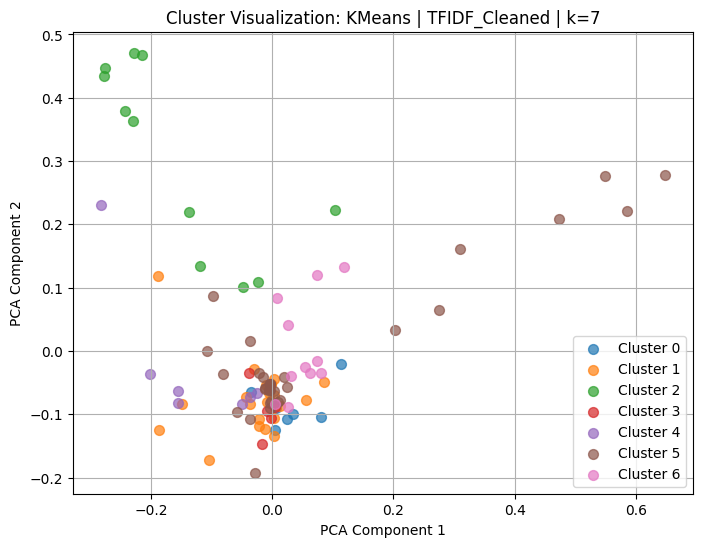


== Agglomerative | TFIDF_Cleaned | Clusters = 3 ==

-- Cluster 0 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150...
> Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me...
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...

-- Cluster 1 --
> Call me when u finish then i come n pick u....
> What's up. Do you want me to come online?...
> When can Ì_ come out?...
> K, if u bored up just come to my home.....
> I'm home......

-- Cluster 2 --
> Wat Ì_ doing now?...
> So wat's da decision?...
> Not yet chikku..wat abt u?...


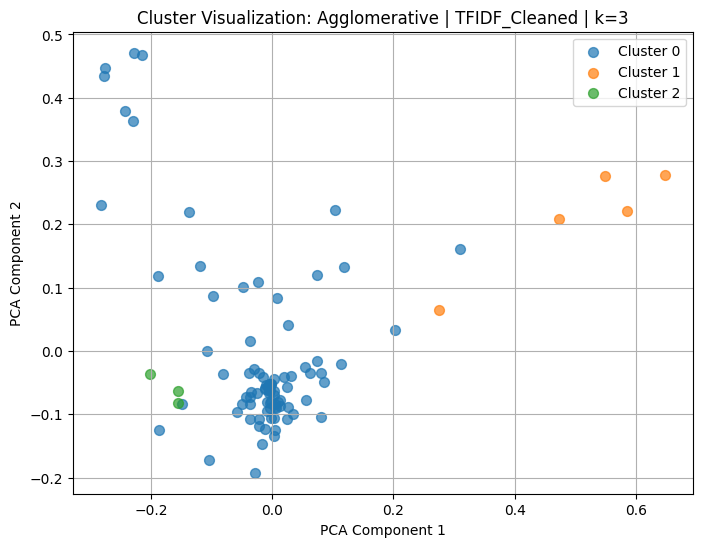


== Agglomerative | TFIDF_Cleaned | Clusters = 5 ==

-- Cluster 0 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...
> K.i did't see you.:)k:)where are you now?...
> No message..no responce..what happend?...

-- Cluster 1 --
> Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me...
> I'll text carlos and let you know, hang on...
> Free tones Hope you enjoyed your new content. text stop to 61610 to unsubscribe. help:08712400602450...
> URGENT! Your mobile was awarded a å£1,500 Bonus Caller Prize on 27/6/03. Our final attempt 2 contact...
> This is the 2nd time we have tried 2 contact u. U have won the å£750 Pound prize. 2 claim is easy, c...

-- Cluster 2 --
> Wat Ì_ doing n

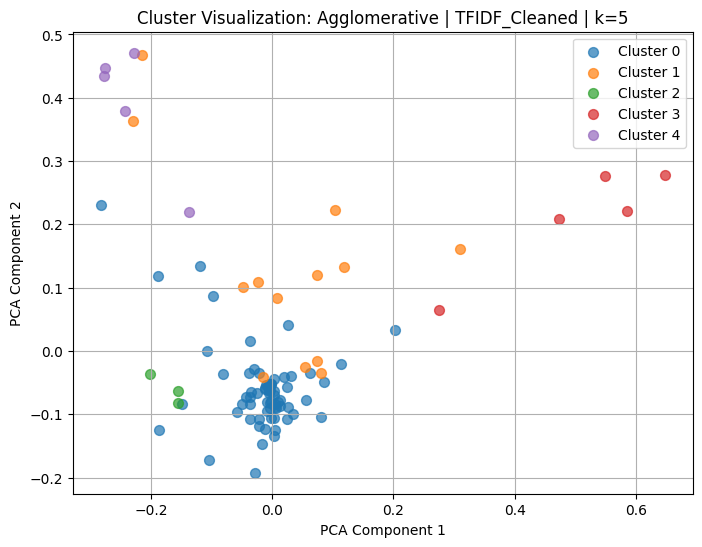


== Agglomerative | TFIDF_Cleaned | Clusters = 7 ==

-- Cluster 0 --
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...
> HMV BONUS SPECIAL 500 pounds of genuine HMV vouchers to be won. Just answer 4 easy questions. Play N...
> Daddy will take good care of you :)...
> Ur HMV Quiz cash-balance is currently å£500 - to maximize ur cash-in now send HMV1 to 86688 only 150...
> THATåÕS ALRITE GIRL, U KNOW GAIL IS NEVA WRONG!!TAKE CARE SWEET AND DONåÕT WORRY.C U L8TR HUN!LOVE Y...

-- Cluster 1 --
> Free tones Hope you enjoyed your new content. text stop to 61610 to unsubscribe. help:08712400602450...
> URGENT! Your mobile was awarded a å£1,500 Bonus Caller Prize on 27/6/03. Our final attempt 2 contact...
> This is the 2nd time we have tried 2 contact u. U have won the å£750 Pound prize. 2 claim is easy, c...
> We tried to call you re your reply to our sms for a video mobile 750 mins UNLIMITED TEXT free camcor...
> Do you want a New Nokia

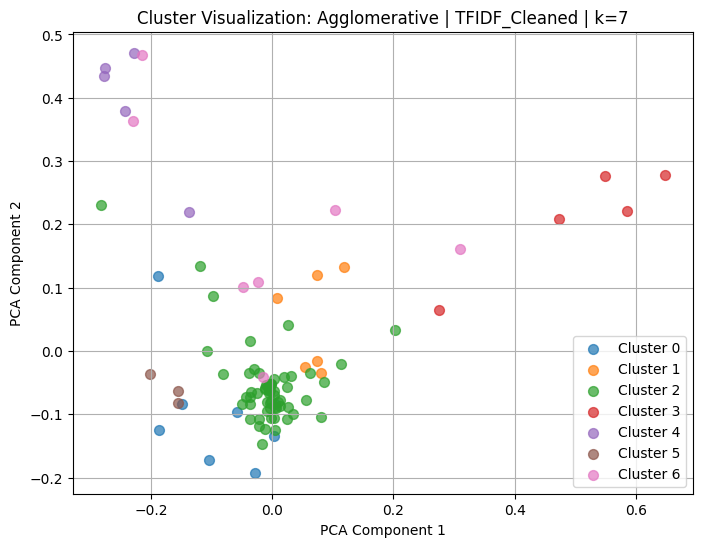


== GMM | TFIDF_Cleaned | Clusters = 3 ==

-- Cluster 0 --
> Dear how is chechi. Did you talk to her...
> No it was cancelled yeah baby! Well that sounds important so i understand my darlin give me a ring l...
> Done it but internet connection v slow and canÛ÷t send it. Will try again later or first thing tomo...
> I can't speak, bcaz mobile have problem. I can listen you but you cann't listen my voice. So i calls...
> Hey mate. Spoke to the mag people. WeÛ÷re on.  the is deliver by the end of the month. Deliver on t...

-- Cluster 1 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...
> K.i did't see you.:)k:)where are you now?...
> No message..no responce..what happend?...

-- Cluster 2 --
> We know someone who you kno

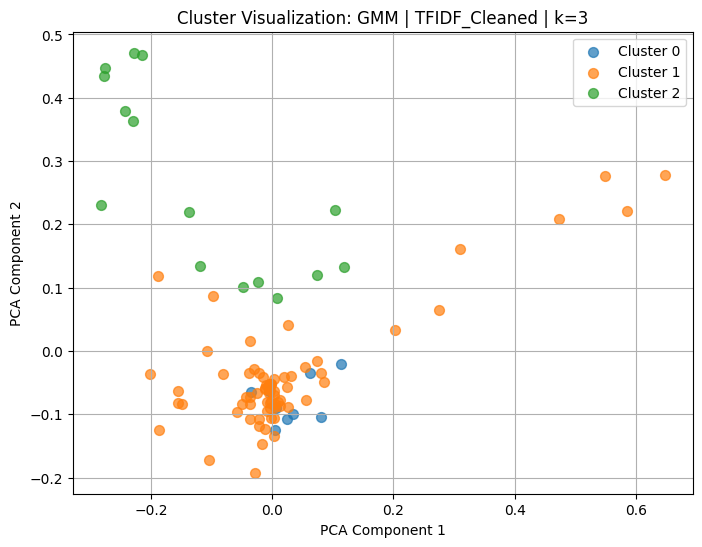


== GMM | TFIDF_Cleaned | Clusters = 5 ==

-- Cluster 0 --
> Dear how is chechi. Did you talk to her...
> No it was cancelled yeah baby! Well that sounds important so i understand my darlin give me a ring l...
> Done it but internet connection v slow and canÛ÷t send it. Will try again later or first thing tomo...
> I can't speak, bcaz mobile have problem. I can listen you but you cann't listen my voice. So i calls...
> Hey mate. Spoke to the mag people. WeÛ÷re on.  the is deliver by the end of the month. Deliver on t...

-- Cluster 1 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...
> K.i did't see you.:)k:)where are you now?...
> No message..no responce..what happend?...

-- Cluster 2 --
> We know someone who you kno

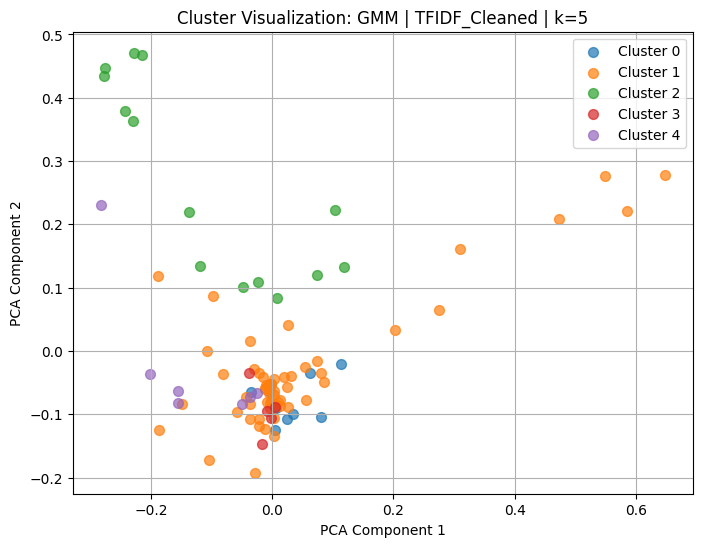


== GMM | TFIDF_Cleaned | Clusters = 7 ==

-- Cluster 0 --
> Dear how is chechi. Did you talk to her...
> No it was cancelled yeah baby! Well that sounds important so i understand my darlin give me a ring l...
> Done it but internet connection v slow and canÛ÷t send it. Will try again later or first thing tomo...
> Hey mate. Spoke to the mag people. WeÛ÷re on.  the is deliver by the end of the month. Deliver on t...
> Hey gals...U all wanna meet 4 dinner at nÌÂte? ...

-- Cluster 1 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> K.i did't see you.:)k:)where are you now?...
> No message..no responce..what happend?...
> For real tho this sucks. I can't even cook my whole electricity is out. And I'm hungry....
> Its not the same here. Still looking for a job. How much do Ta's earn there....

-- Cluster 2 --
> We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150...
> Only if you

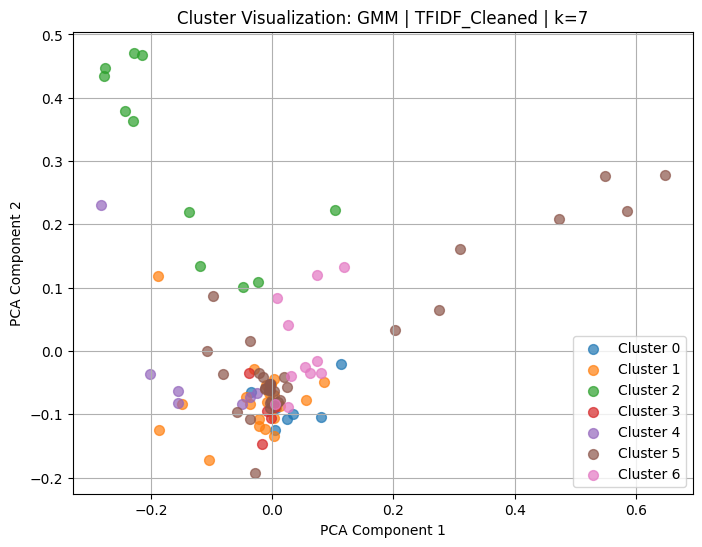


== Spectral | TFIDF_Cleaned | Clusters = 3 ==

-- Cluster 0 --
> We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150...
> Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me...
> I'll text carlos and let you know, hang on...
> Hi I'm sue. I am 20 years old and work as a lapdancer. I love sex. Text me live - I'm i my bedroom n...
> I know you mood off today...

-- Cluster 1 --
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...
> Free tones Hope you enjoyed your new content. text stop to 61610 to unsubscribe. help:08712400602450...
> Call me when u finish then i come n pick u....
> What's up. Do you want me to come online?...
> URGENT! Your mobile was awarded a å£1,500 Bonus Caller Prize on 27/6/03. Our final attempt 2 contact...

-- Cluster 2 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn 

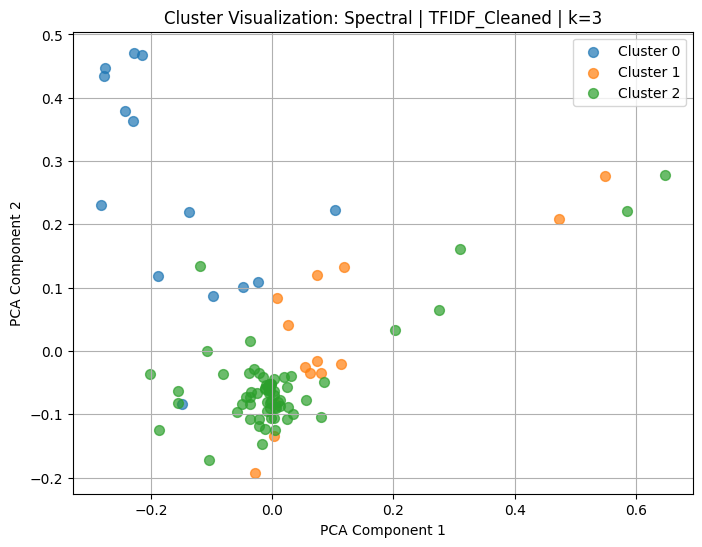


== Spectral | TFIDF_Cleaned | Clusters = 5 ==

-- Cluster 0 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> K.i did't see you.:)k:)where are you now?...
> No message..no responce..what happend?...
> Get down in gandhipuram and walk to cross cut road. Right side &lt;#&gt; street road and turn at fir...
> You flippin your shit yet?...

-- Cluster 1 --
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...
> I'll reach in ard 20 mins ok......
> Can you pls send me that company name. In saibaba colany...
> Aft i finish my lunch then i go str down lor. Ard 3 smth lor. U finish ur lunch already?...
> that would be good Û_ I'll phone you tomo lunchtime, shall I, to organise something?...

-- Cluster 2 --
> Free tones Hope you enjoyed your new content. text stop to 61610 to unsubscribe. help:08712400602450...
> What's up. Do you want me to come online?...
> When can Ì_ come out?.

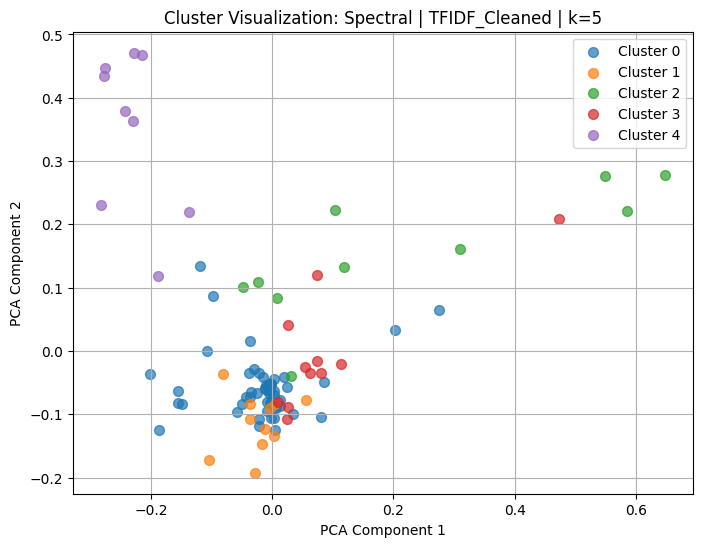


== Spectral | TFIDF_Cleaned | Clusters = 7 ==

-- Cluster 0 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> K.i did't see you.:)k:)where are you now?...
> No message..no responce..what happend?...
> Get down in gandhipuram and walk to cross cut road. Right side &lt;#&gt; street road and turn at fir...
> You flippin your shit yet?...

-- Cluster 1 --
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...
> I'll reach in ard 20 mins ok......
> Can you pls send me that company name. In saibaba colany...
> Aft i finish my lunch then i go str down lor. Ard 3 smth lor. U finish ur lunch already?...
> HMV BONUS SPECIAL 500 pounds of genuine HMV vouchers to be won. Just answer 4 easy questions. Play N...

-- Cluster 2 --
> We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150...
> Only if you promise your getting out as SOON as you ca

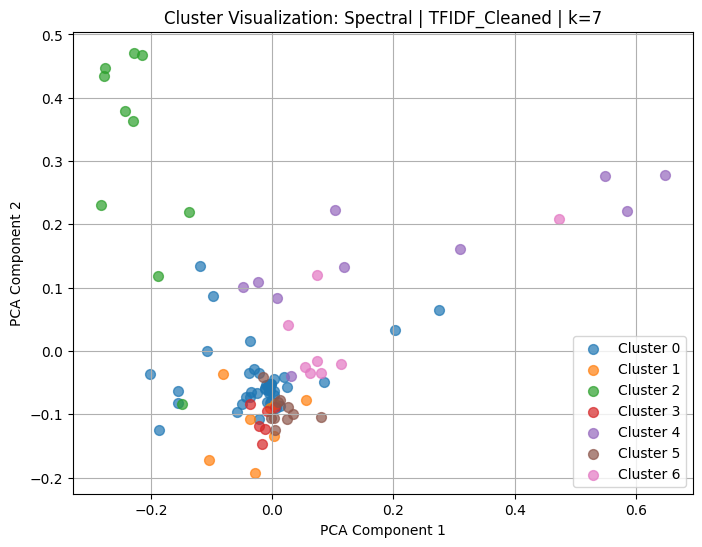


== DBSCAN | TFIDF_Cleaned | Clusters = 3 ==


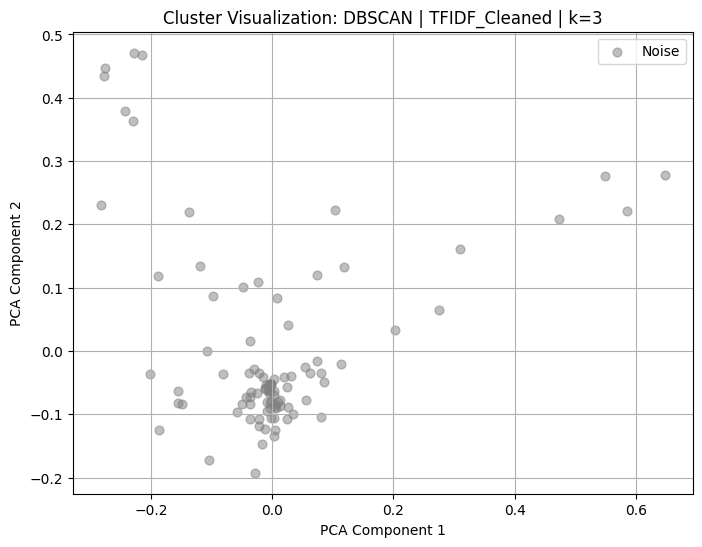


== DBSCAN | TFIDF_Cleaned | Clusters = 5 ==


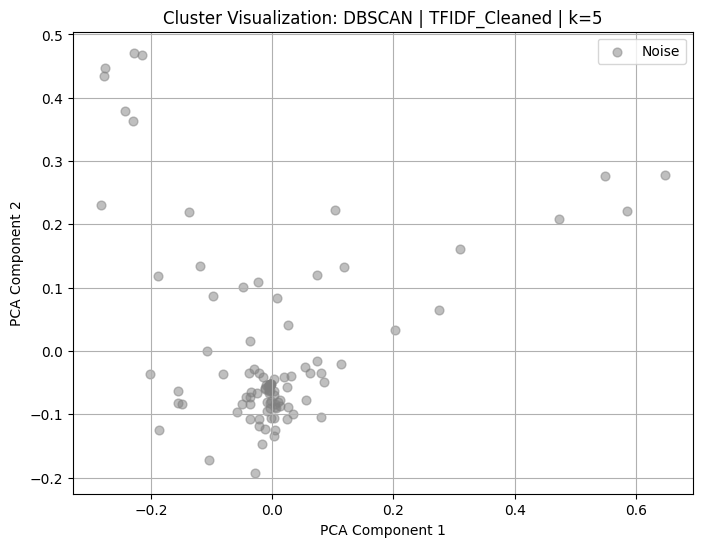


== DBSCAN | TFIDF_Cleaned | Clusters = 7 ==


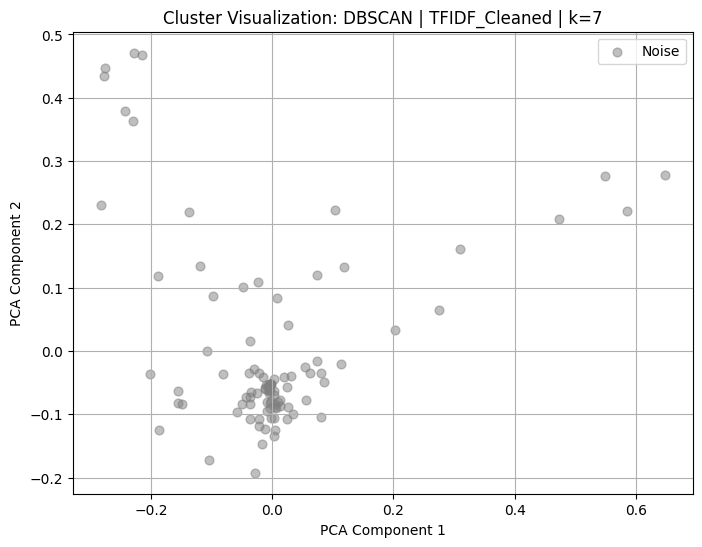


--- Clustering for Embedding - all-MiniLM-L6-v2 (Cleaned) ---

== KMeans | Embedding - all-MiniLM-L6-v2 (Cleaned) | Clusters = 3 ==

-- Cluster 0 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...
> Get down in gandhipuram and walk to cross cut road. Right side &lt;#&gt; street road and turn at fir...
> This is the 2nd time we have tried 2 contact u. U have won the å£750 Pound prize. 2 claim is easy, c...

-- Cluster 1 --
> You flippin your shit yet?...
> For real tho this sucks. I can't even cook my whole electricity is out. And I'm hungry....
> I'm wif him now buying tix lar......
> K, if u bored up just come to my home.....
> Boy; I love u Grl: Hogolo Boy: gold chain kodstini Grl: Agalla Boy: necklace madstini Grl: a

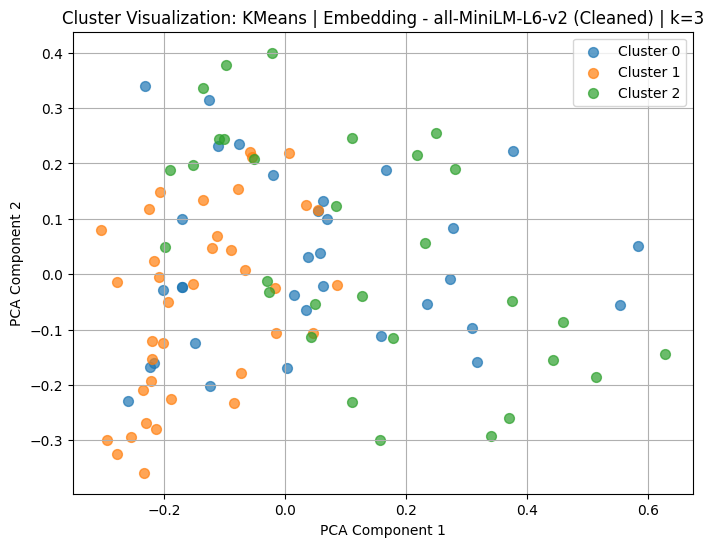


== KMeans | Embedding - all-MiniLM-L6-v2 (Cleaned) | Clusters = 5 ==

-- Cluster 0 --
> This is the 2nd time we have tried 2 contact u. U have won the å£750 Pound prize. 2 claim is easy, c...
> Can you pls send me that company name. In saibaba colany...
> Yes i think so. I am in office but my lap is in room i think thats on for the last few days. I didnt...
> Hey mate. Spoke to the mag people. WeÛ÷re on.  the is deliver by the end of the month. Deliver on t...
> Lol ... I knew that .... I saw him in the dollar store...

-- Cluster 1 --
> Boy; I love u Grl: Hogolo Boy: gold chain kodstini Grl: Agalla Boy: necklace madstini Grl: agalla Bo...
> No it was cancelled yeah baby! Well that sounds important so i understand my darlin give me a ring l...
> Yeah it's jus rite......
> Yeah there's barely enough room for the two of us, x has too many fucking shoes. Sorry man, see you ...
> That's y i said it's bad dat all e gals know u... Wat u doing now?...

-- Cluster 2 --
> Only if you promise 

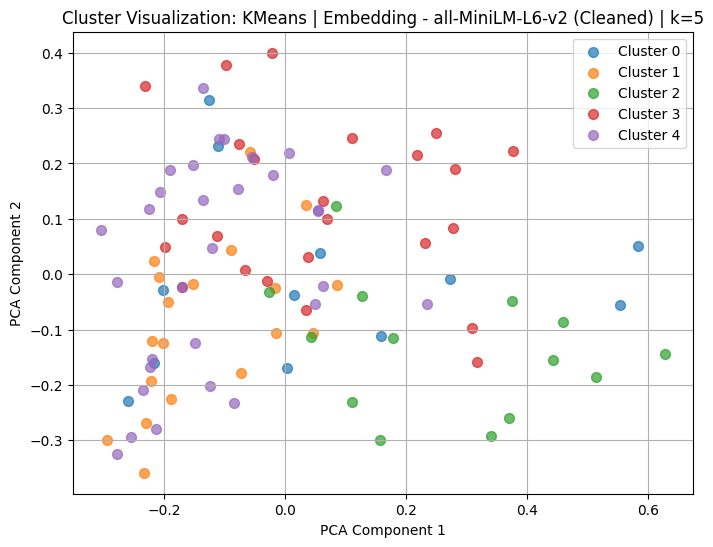


== KMeans | Embedding - all-MiniLM-L6-v2 (Cleaned) | Clusters = 7 ==

-- Cluster 0 --
> Can you pls send me that company name. In saibaba colany...
> Yes i think so. I am in office but my lap is in room i think thats on for the last few days. I didnt...
> Hey mate. Spoke to the mag people. WeÛ÷re on.  the is deliver by the end of the month. Deliver on t...
> Lol ... I knew that .... I saw him in the dollar store...
> If i let you do this, i want you in the house by 8am....

-- Cluster 1 --
> Boy; I love u Grl: Hogolo Boy: gold chain kodstini Grl: Agalla Boy: necklace madstini Grl: agalla Bo...
> No it was cancelled yeah baby! Well that sounds important so i understand my darlin give me a ring l...
> Yeah it's jus rite......
> Yeah there's barely enough room for the two of us, x has too many fucking shoes. Sorry man, see you ...
> That's y i said it's bad dat all e gals know u... Wat u doing now?...

-- Cluster 2 --
> Only if you promise your getting out as SOON as you can. And you'll

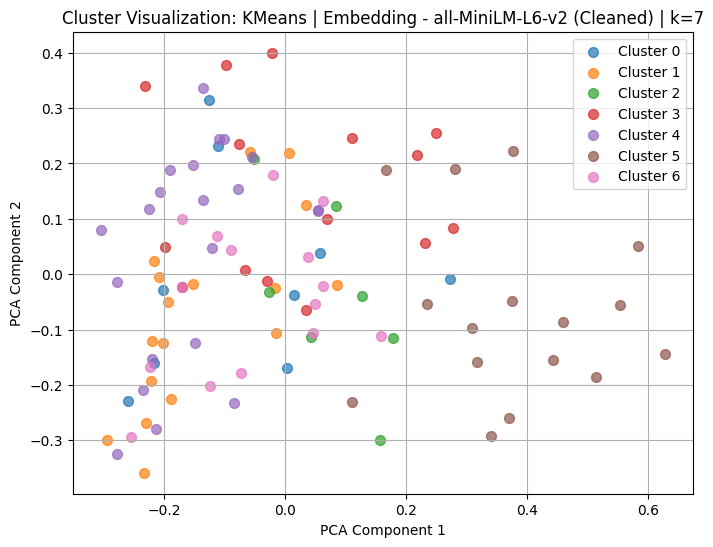


== Agglomerative | Embedding - all-MiniLM-L6-v2 (Cleaned) | Clusters = 3 ==

-- Cluster 0 --
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150...
> Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me...
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...
> I'll text carlos and let you know, hang on...

-- Cluster 1 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> K.i did't see you.:)k:)where are you now?...
> Get down in gandhipuram and walk to cross cut road. Right side &lt;#&gt; street road and turn at fir...
> You flippin your shit yet?...
> For real tho this sucks. I can't even cook my whole electricity is out. And I'm hungry....

-- Cluster 2 --
> K, if u bored 

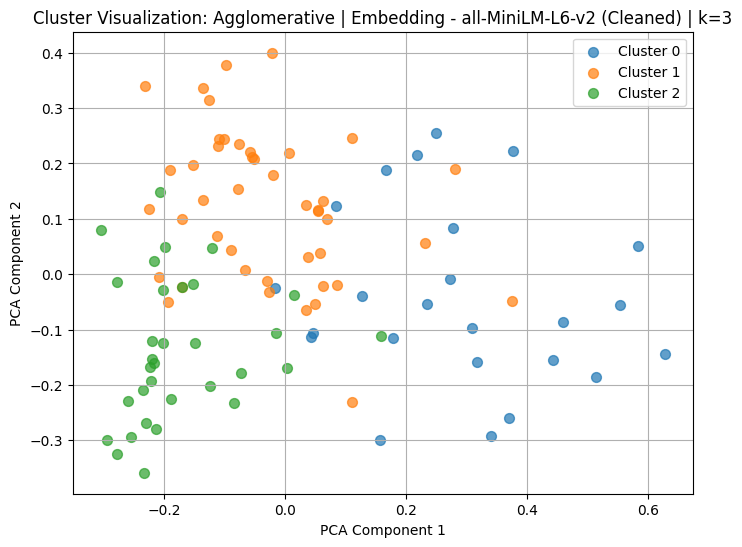


== Agglomerative | Embedding - all-MiniLM-L6-v2 (Cleaned) | Clusters = 5 ==

-- Cluster 0 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> K.i did't see you.:)k:)where are you now?...
> Get down in gandhipuram and walk to cross cut road. Right side &lt;#&gt; street road and turn at fir...
> You flippin your shit yet?...
> For real tho this sucks. I can't even cook my whole electricity is out. And I'm hungry....

-- Cluster 1 --
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me...
> I'll text carlos and let you know, hang on...
> No message..no responce..what happend?...
> Free tones Hope you enjoyed your new content. text stop to 61610 to unsubscribe. help:08712400602450...

-- Cluster 2 --
> K, if u bored up just come to my home.....
> Boy; I love u Grl: Hogolo Boy: 

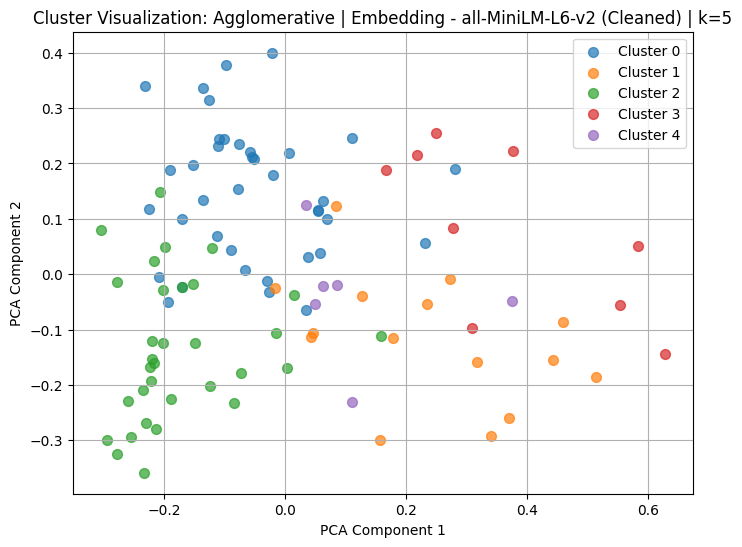


== Agglomerative | Embedding - all-MiniLM-L6-v2 (Cleaned) | Clusters = 7 ==

-- Cluster 0 --
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me...
> I'll text carlos and let you know, hang on...
> No message..no responce..what happend?...
> Free tones Hope you enjoyed your new content. text stop to 61610 to unsubscribe. help:08712400602450...

-- Cluster 1 --
> K, if u bored up just come to my home.....
> Yup. Izzit still raining heavily cos i'm in e mrt i can't c outside....
> Yes i think so. I am in office but my lap is in room i think thats on for the last few days. I didnt...
> Hey mate. Spoke to the mag people. WeÛ÷re on.  the is deliver by the end of the month. Deliver on t...
> I know you mood off today...

-- Cluster 2 --
> Get down in gandhipuram and walk to cross cut road. Right side &lt;#&gt; street road and turn at f

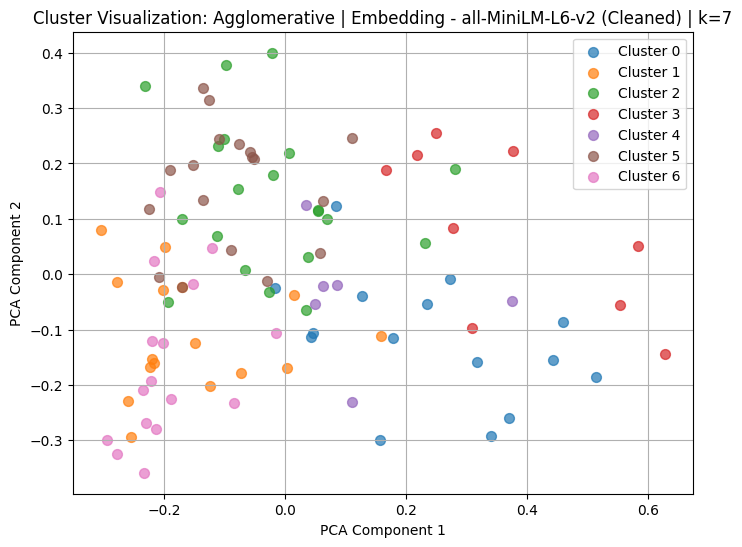


== GMM | Embedding - all-MiniLM-L6-v2 (Cleaned) | Clusters = 3 ==

-- Cluster 0 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...
> Get down in gandhipuram and walk to cross cut road. Right side &lt;#&gt; street road and turn at fir...
> This is the 2nd time we have tried 2 contact u. U have won the å£750 Pound prize. 2 claim is easy, c...

-- Cluster 1 --
> You flippin your shit yet?...
> For real tho this sucks. I can't even cook my whole electricity is out. And I'm hungry....
> I'm wif him now buying tix lar......
> K, if u bored up just come to my home.....
> Boy; I love u Grl: Hogolo Boy: gold chain kodstini Grl: Agalla Boy: necklace madstini Grl: agalla Bo...

-- Cluster 2 --
> We know someone who you know that f

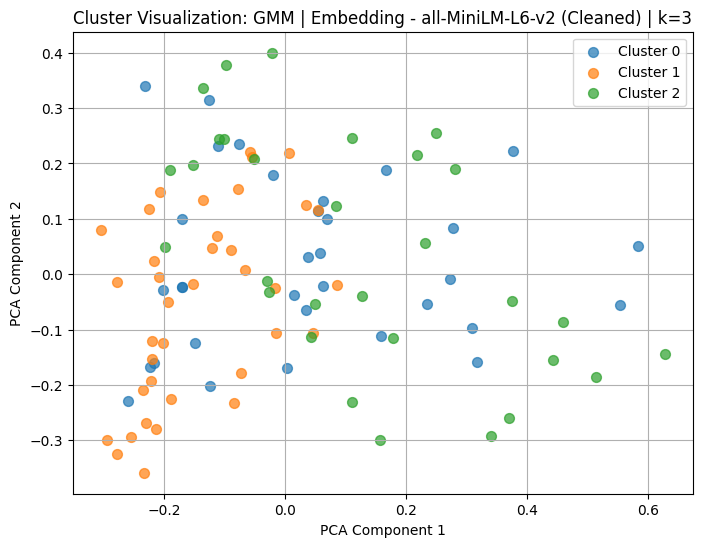


== GMM | Embedding - all-MiniLM-L6-v2 (Cleaned) | Clusters = 5 ==

-- Cluster 0 --
> This is the 2nd time we have tried 2 contact u. U have won the å£750 Pound prize. 2 claim is easy, c...
> Can you pls send me that company name. In saibaba colany...
> Yes i think so. I am in office but my lap is in room i think thats on for the last few days. I didnt...
> Hey mate. Spoke to the mag people. WeÛ÷re on.  the is deliver by the end of the month. Deliver on t...
> Lol ... I knew that .... I saw him in the dollar store...

-- Cluster 1 --
> Boy; I love u Grl: Hogolo Boy: gold chain kodstini Grl: Agalla Boy: necklace madstini Grl: agalla Bo...
> No it was cancelled yeah baby! Well that sounds important so i understand my darlin give me a ring l...
> Yeah it's jus rite......
> Yeah there's barely enough room for the two of us, x has too many fucking shoes. Sorry man, see you ...
> That's y i said it's bad dat all e gals know u... Wat u doing now?...

-- Cluster 2 --
> Only if you promise you

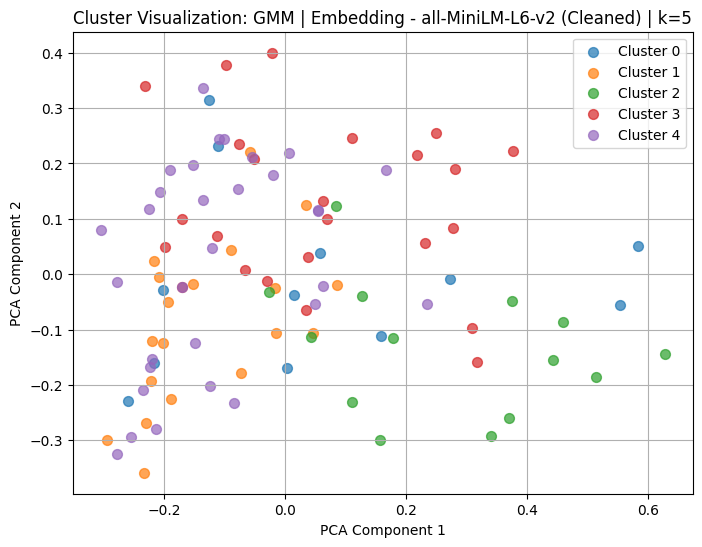


== GMM | Embedding - all-MiniLM-L6-v2 (Cleaned) | Clusters = 7 ==

-- Cluster 0 --
> Can you pls send me that company name. In saibaba colany...
> Yes i think so. I am in office but my lap is in room i think thats on for the last few days. I didnt...
> Hey mate. Spoke to the mag people. WeÛ÷re on.  the is deliver by the end of the month. Deliver on t...
> Lol ... I knew that .... I saw him in the dollar store...
> If i let you do this, i want you in the house by 8am....

-- Cluster 1 --
> Boy; I love u Grl: Hogolo Boy: gold chain kodstini Grl: Agalla Boy: necklace madstini Grl: agalla Bo...
> No it was cancelled yeah baby! Well that sounds important so i understand my darlin give me a ring l...
> Yeah it's jus rite......
> Yeah there's barely enough room for the two of us, x has too many fucking shoes. Sorry man, see you ...
> That's y i said it's bad dat all e gals know u... Wat u doing now?...

-- Cluster 2 --
> Only if you promise your getting out as SOON as you can. And you'll te

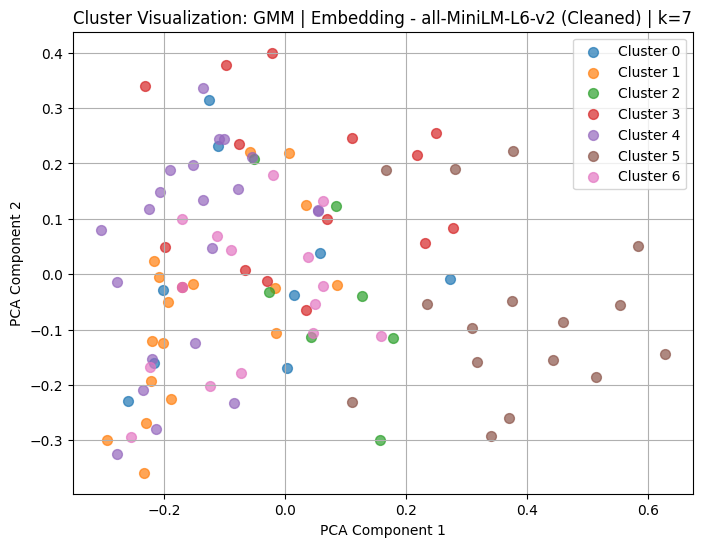


== Spectral | Embedding - all-MiniLM-L6-v2 (Cleaned) | Clusters = 3 ==

-- Cluster 0 --
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150...
> Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me...
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...
> I'll text carlos and let you know, hang on...

-- Cluster 1 --
> K.i did't see you.:)k:)where are you now?...
> You flippin your shit yet?...
> For real tho this sucks. I can't even cook my whole electricity is out. And I'm hungry....
> I'm wif him now buying tix lar......
> What's up. Do you want me to come online?...

-- Cluster 2 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> Get down in gandhipuram and walk to cro

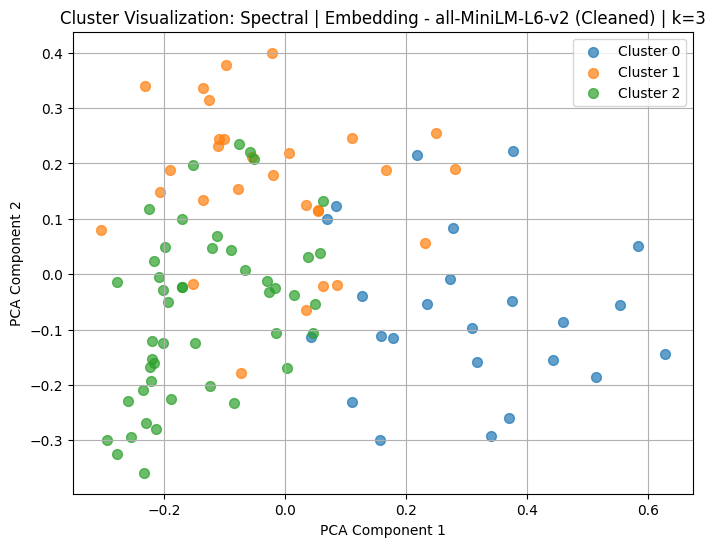


== Spectral | Embedding - all-MiniLM-L6-v2 (Cleaned) | Clusters = 5 ==

-- Cluster 0 --
> K.i did't see you.:)k:)where are you now?...
> You flippin your shit yet?...
> For real tho this sucks. I can't even cook my whole electricity is out. And I'm hungry....
> I'm wif him now buying tix lar......
> What's up. Do you want me to come online?...

-- Cluster 1 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> Get down in gandhipuram and walk to cross cut road. Right side &lt;#&gt; street road and turn at fir...
> Call me when u finish then i come n pick u....
> Can Ì_ call me at 10:10 to make sure dat i've woken up......
> A bloo bloo bloo I'll miss the first bowl...

-- Cluster 2 --
> Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me...
> I'll text carlos and let you know, hang on...
> No message..no responce..what happend?...
> Free tones Hope you enjoyed your new content. te

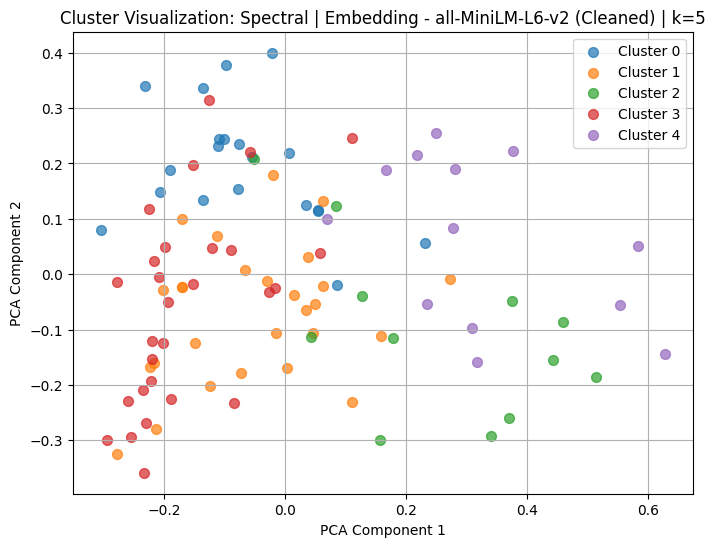


== Spectral | Embedding - all-MiniLM-L6-v2 (Cleaned) | Clusters = 7 ==

-- Cluster 0 --
> I'll text carlos and let you know, hang on...
> No message..no responce..what happend?...
> Free tones Hope you enjoyed your new content. text stop to 61610 to unsubscribe. help:08712400602450...
> Hi I'm sue. I am 20 years old and work as a lapdancer. I love sex. Text me live - I'm i my bedroom n...
> I can't speak, bcaz mobile have problem. I can listen you but you cann't listen my voice. So i calls...

-- Cluster 1 --
> Get down in gandhipuram and walk to cross cut road. Right side &lt;#&gt; street road and turn at fir...
> Dear how is chechi. Did you talk to her...
> Can Ì_ call me at 10:10 to make sure dat i've woken up......
> A bloo bloo bloo I'll miss the first bowl...
> Gud gud..k, chikku tke care.. sleep well gud nyt...

-- Cluster 2 --
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> We know someone who you know that fancies yo

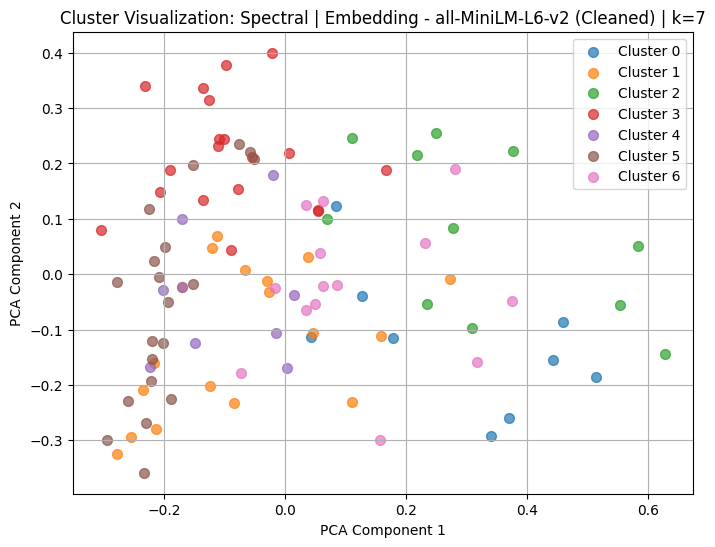


== DBSCAN | Embedding - all-MiniLM-L6-v2 (Cleaned) | Clusters = 3 ==


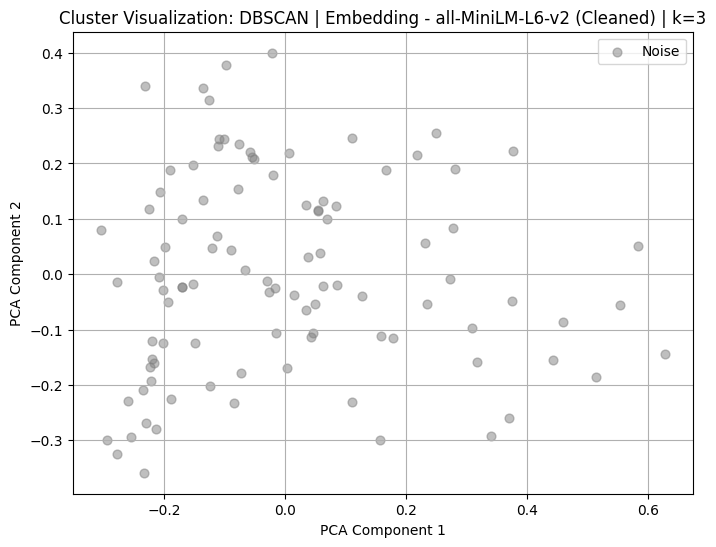


== DBSCAN | Embedding - all-MiniLM-L6-v2 (Cleaned) | Clusters = 5 ==


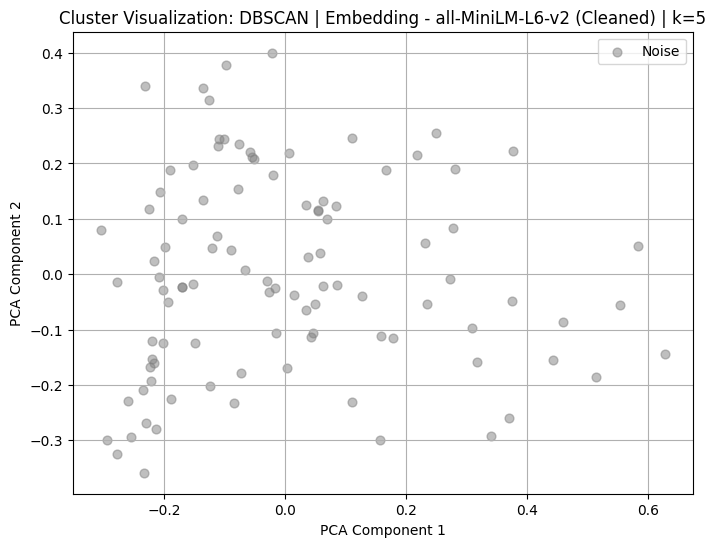


== DBSCAN | Embedding - all-MiniLM-L6-v2 (Cleaned) | Clusters = 7 ==


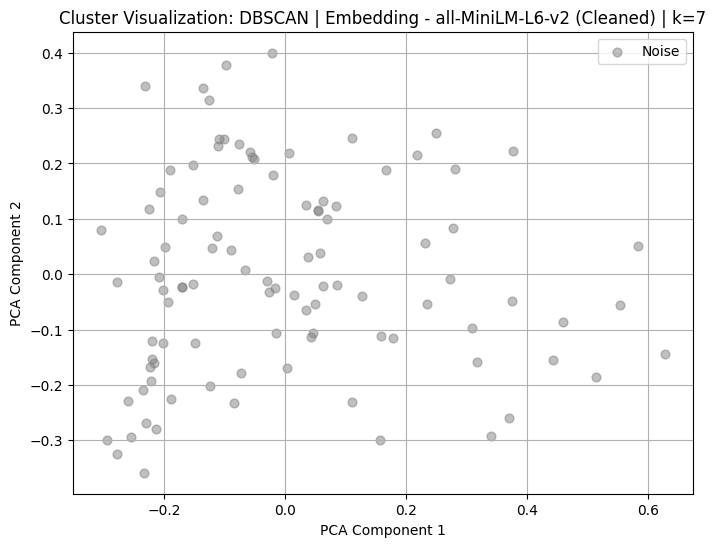


--- Clustering for Embedding - paraphrase-MiniLM-L6-v2 (Cleaned) ---

== KMeans | Embedding - paraphrase-MiniLM-L6-v2 (Cleaned) | Clusters = 3 ==

-- Cluster 0 --
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150...
> Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me...
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...
> I'll text carlos and let you know, hang on...

-- Cluster 1 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> You flippin your shit yet?...
> For real tho this sucks. I can't even cook my whole electricity is out. And I'm hungry....
> I'm wif him now buying tix lar......
> Call me when u finish then i come n pick u....

-- Cluster 2 --
> K.i did't

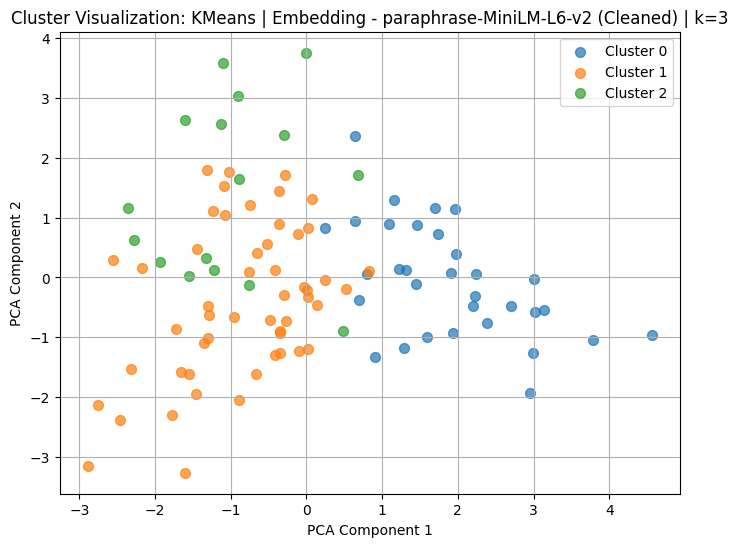


== KMeans | Embedding - paraphrase-MiniLM-L6-v2 (Cleaned) | Clusters = 5 ==

-- Cluster 0 --
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me...
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...
> I'll text carlos and let you know, hang on...
> No message..no responce..what happend?...

-- Cluster 1 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> You flippin your shit yet?...
> For real tho this sucks. I can't even cook my whole electricity is out. And I'm hungry....
> I'm wif him now buying tix lar......
> Call me when u finish then i come n pick u....

-- Cluster 2 --
> K.i did't see you.:)k:)where are you now?...
> Dear how is chechi. Did you talk to her...
> When can Ì_ come out?...
> K, if u bored up just 

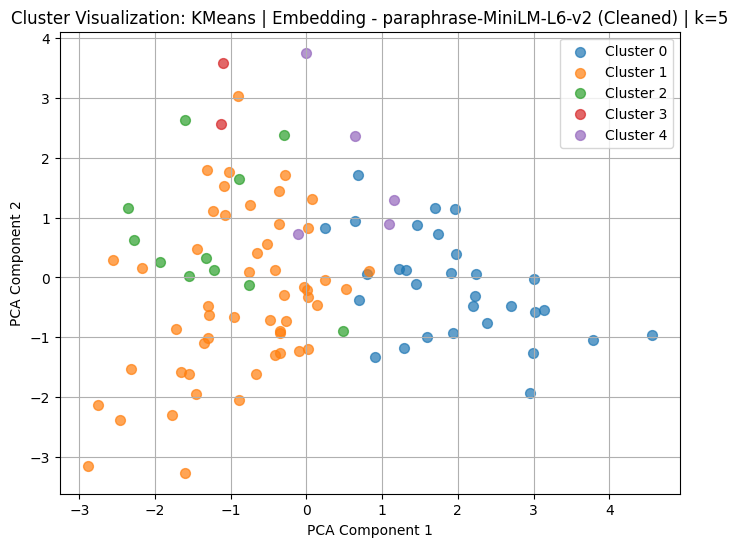


== KMeans | Embedding - paraphrase-MiniLM-L6-v2 (Cleaned) | Clusters = 7 ==

-- Cluster 0 --
> Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me...
> No message..no responce..what happend?...
> Free tones Hope you enjoyed your new content. text stop to 61610 to unsubscribe. help:08712400602450...
> What's up. Do you want me to come online?...
> Can Ì_ call me at 10:10 to make sure dat i've woken up......

-- Cluster 1 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> You flippin your shit yet?...
> For real tho this sucks. I can't even cook my whole electricity is out. And I'm hungry....
> I'm wif him now buying tix lar......
> Call me when u finish then i come n pick u....

-- Cluster 2 --
> K.i did't see you.:)k:)where are you now?...
> When can Ì_ come out?...
> K, if u bored up just come to my home.....
> Just do what ever is easier for you...
> K:)eng rocking in ashes:)

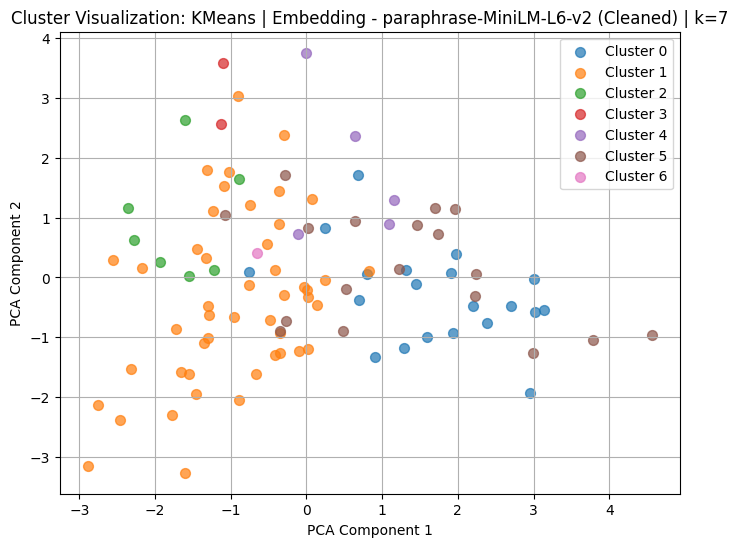


== Agglomerative | Embedding - paraphrase-MiniLM-L6-v2 (Cleaned) | Clusters = 3 ==

-- Cluster 0 --
> We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150...
> Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me...
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...
> I'll text carlos and let you know, hang on...
> No message..no responce..what happend?...

-- Cluster 1 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> K.i did't see you.:)k:)where are you now?...
> You flippin your shit yet?...
> For real tho this sucks. I can't even cook my whole electricity is out. And I'm hungry....

-- Cluster 2 --
> Get down in gandhipuram and walk to cross cut road. Right side &lt;#&

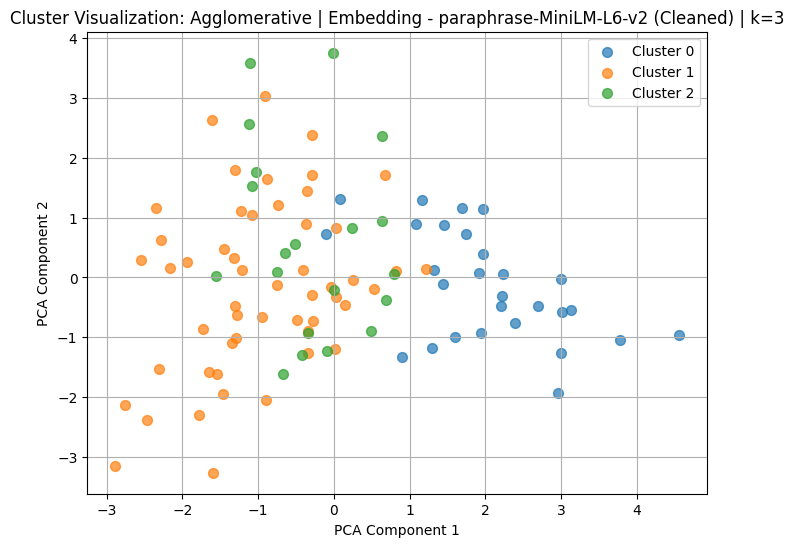


== Agglomerative | Embedding - paraphrase-MiniLM-L6-v2 (Cleaned) | Clusters = 5 ==

-- Cluster 0 --
> Get down in gandhipuram and walk to cross cut road. Right side &lt;#&gt; street road and turn at fir...
> Were somewhere on Fredericksburg...
> K, if u bored up just come to my home.....
> A bloo bloo bloo I'll miss the first bowl...
> Gud gud..k, chikku tke care.. sleep well gud nyt...

-- Cluster 1 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> You flippin your shit yet?...
> For real tho this sucks. I can't even cook my whole electricity is out. And I'm hungry....
> Call me when u finish then i come n pick u....
> When can Ì_ come out?...

-- Cluster 2 --
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> K.i did't see you.:)k:)where are you now?...
> I'm wif him now buying tix lar......
> Dear how is chechi. Did you talk to her...
> What's up. Do you want me to 

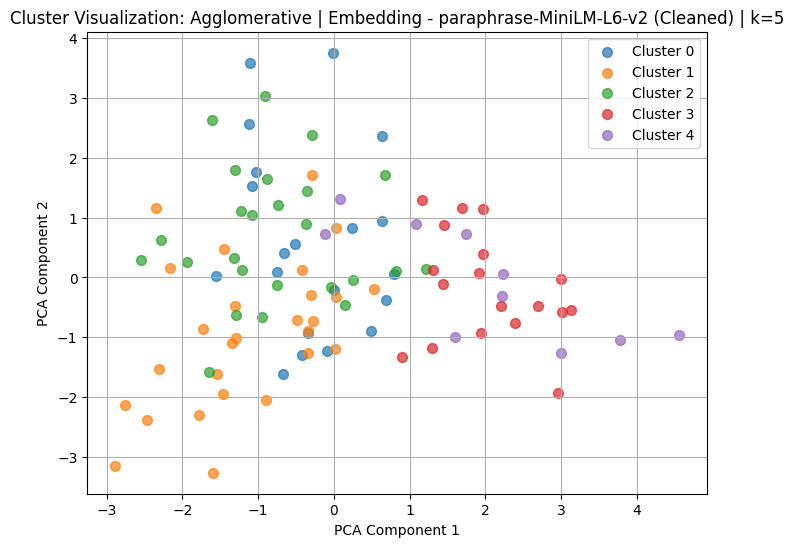


== Agglomerative | Embedding - paraphrase-MiniLM-L6-v2 (Cleaned) | Clusters = 7 ==

-- Cluster 0 --
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> I'm wif him now buying tix lar......
> What's up. Do you want me to come online?...
> Its not the same here. Still looking for a job. How much do Ta's earn there....
> Alrite jod hows the revision goin? Keris bin doin a smidgin. N e way u wanna cum over after college?...

-- Cluster 1 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> You flippin your shit yet?...
> For real tho this sucks. I can't even cook my whole electricity is out. And I'm hungry....
> Call me when u finish then i come n pick u....
> When can Ì_ come out?...

-- Cluster 2 --
> Get down in gandhipuram and walk to cross cut road. Right side &lt;#&gt; street road and turn at fir...
> A bloo bloo bloo I'll miss the first bowl...
> Gud gud..k, chikku tke 

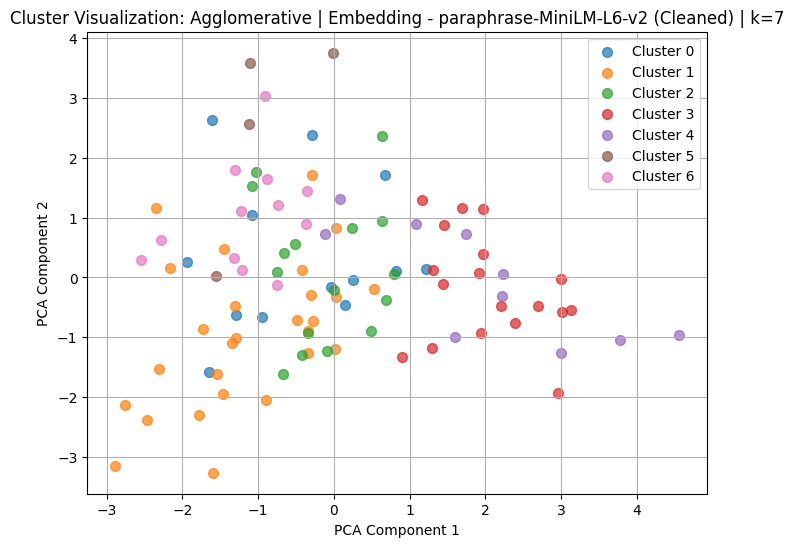


== GMM | Embedding - paraphrase-MiniLM-L6-v2 (Cleaned) | Clusters = 3 ==

-- Cluster 0 --
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150...
> Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me...
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...
> I'll text carlos and let you know, hang on...

-- Cluster 1 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> You flippin your shit yet?...
> For real tho this sucks. I can't even cook my whole electricity is out. And I'm hungry....
> I'm wif him now buying tix lar......
> Call me when u finish then i come n pick u....

-- Cluster 2 --
> K.i did't see you.:)k:)where are you now?...
> Dear how is chechi. Did you talk to

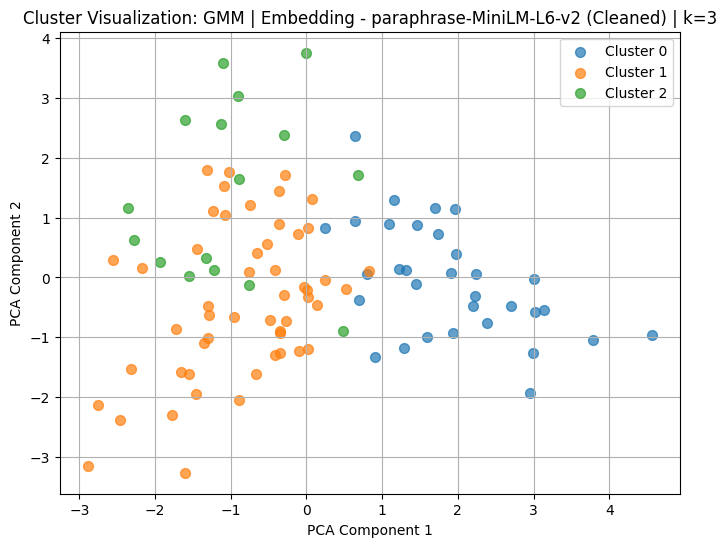


== GMM | Embedding - paraphrase-MiniLM-L6-v2 (Cleaned) | Clusters = 5 ==

-- Cluster 0 --
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me...
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...
> I'll text carlos and let you know, hang on...
> No message..no responce..what happend?...

-- Cluster 1 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> You flippin your shit yet?...
> For real tho this sucks. I can't even cook my whole electricity is out. And I'm hungry....
> I'm wif him now buying tix lar......
> Call me when u finish then i come n pick u....

-- Cluster 2 --
> K.i did't see you.:)k:)where are you now?...
> Dear how is chechi. Did you talk to her...
> When can Ì_ come out?...
> K, if u bored up just com

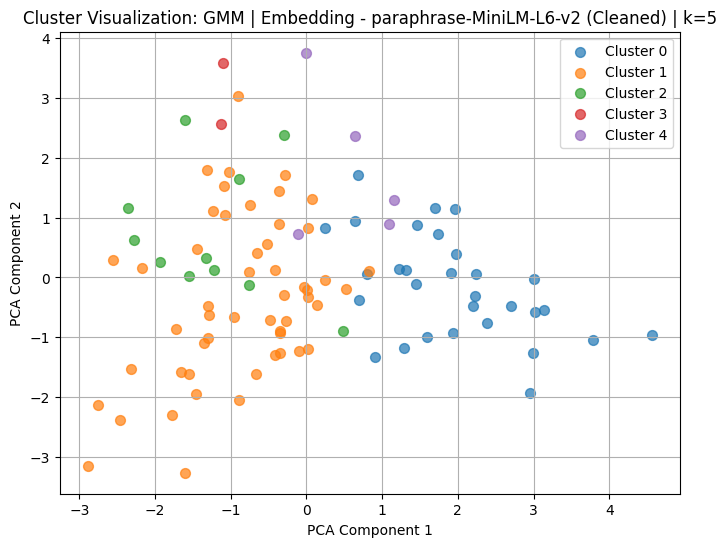


== GMM | Embedding - paraphrase-MiniLM-L6-v2 (Cleaned) | Clusters = 7 ==

-- Cluster 0 --
> Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me...
> No message..no responce..what happend?...
> Free tones Hope you enjoyed your new content. text stop to 61610 to unsubscribe. help:08712400602450...
> What's up. Do you want me to come online?...
> Can Ì_ call me at 10:10 to make sure dat i've woken up......

-- Cluster 1 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> You flippin your shit yet?...
> For real tho this sucks. I can't even cook my whole electricity is out. And I'm hungry....
> I'm wif him now buying tix lar......
> Call me when u finish then i come n pick u....

-- Cluster 2 --
> K.i did't see you.:)k:)where are you now?...
> When can Ì_ come out?...
> K, if u bored up just come to my home.....
> Just do what ever is easier for you...
> K:)eng rocking in ashes:)...

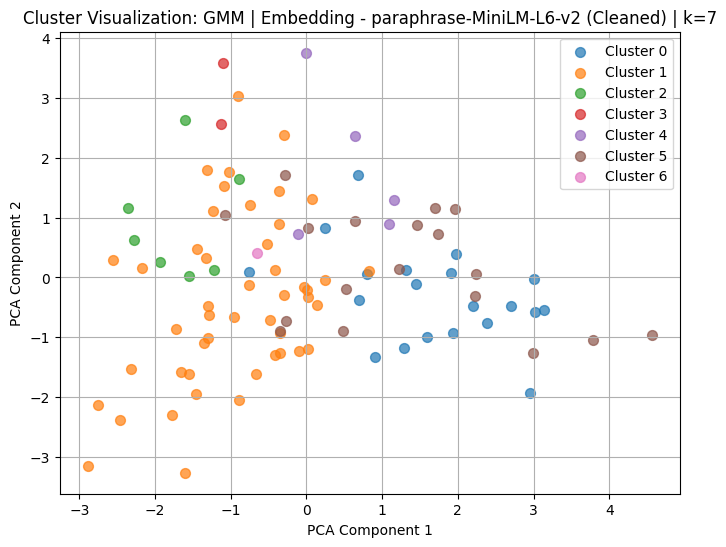


== Spectral | Embedding - paraphrase-MiniLM-L6-v2 (Cleaned) | Clusters = 3 ==

-- Cluster 0 --
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...
> I'm wif him now buying tix lar......
> URGENT! Your mobile was awarded a å£1,500 Bonus Caller Prize on 27/6/03. Our final attempt 2 contact...
> Yeah sure, give me a couple minutes to track down my wallet...
> This is the 2nd time we have tried 2 contact u. U have won the å£750 Pound prize. 2 claim is easy, c...

-- Cluster 1 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150...
> K.i did't see you.:)k:)where are you now?...
> You flippin your shit yet?...

-- Cluster 2 --
> Only if you promise your getting out as SOON as y

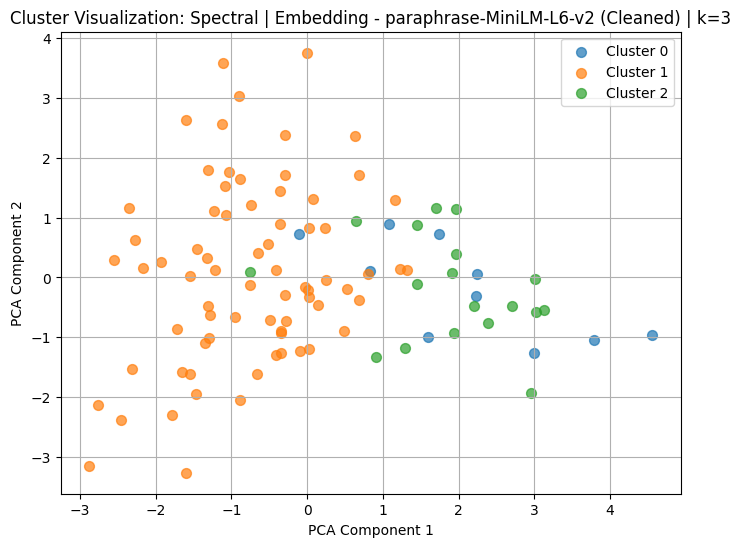


== Spectral | Embedding - paraphrase-MiniLM-L6-v2 (Cleaned) | Clusters = 5 ==

-- Cluster 0 --
> Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me...
> I'll text carlos and let you know, hang on...
> No message..no responce..what happend?...
> Get down in gandhipuram and walk to cross cut road. Right side &lt;#&gt; street road and turn at fir...
> Free tones Hope you enjoyed your new content. text stop to 61610 to unsubscribe. help:08712400602450...

-- Cluster 1 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150...
> You flippin your shit yet?...
> For real tho this sucks. I can't even cook my whole electricity is out. And I'm hungry....
> Dear how is chechi. Did you talk to her...

-- Cluster 2 --
> Call me when u finish then i come n pick u....
> Wat Ì_ doing now?...
> Alri

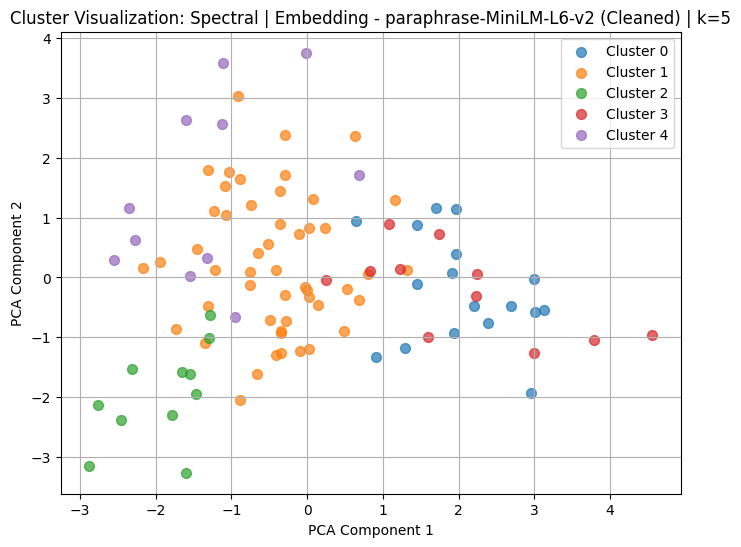


== Spectral | Embedding - paraphrase-MiniLM-L6-v2 (Cleaned) | Clusters = 7 ==

-- Cluster 0 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150...
> I'm wif him now buying tix lar......
> Dear how is chechi. Did you talk to her...

-- Cluster 1 --
> You flippin your shit yet?...
> For real tho this sucks. I can't even cook my whole electricity is out. And I'm hungry....
> Gud gud..k, chikku tke care.. sleep well gud nyt...
> I'll reach in ard 20 mins ok......
> Yup. Izzit still raining heavily cos i'm in e mrt i can't c outside....

-- Cluster 2 --
> K.i did't see you.:)k:)where are you now?...
> What's up. Do you want me to come online?...
> When can Ì_ come out?...
> K, if u bored up just come to my home.....
> If i let y

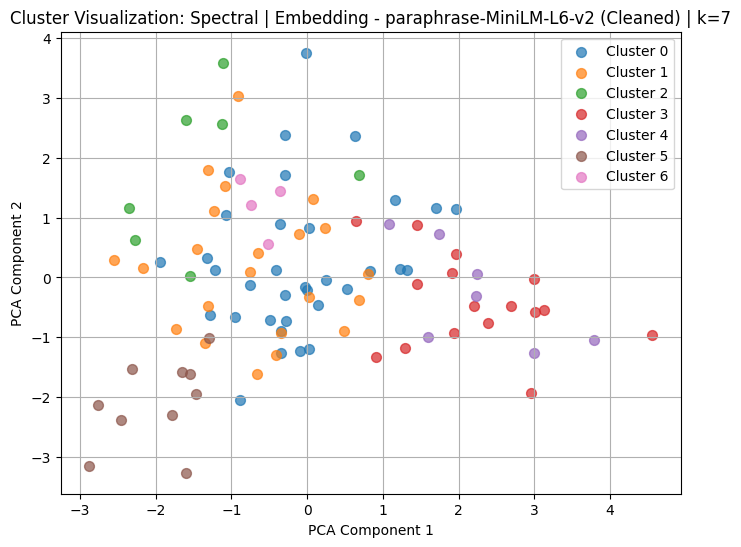


== DBSCAN | Embedding - paraphrase-MiniLM-L6-v2 (Cleaned) | Clusters = 3 ==


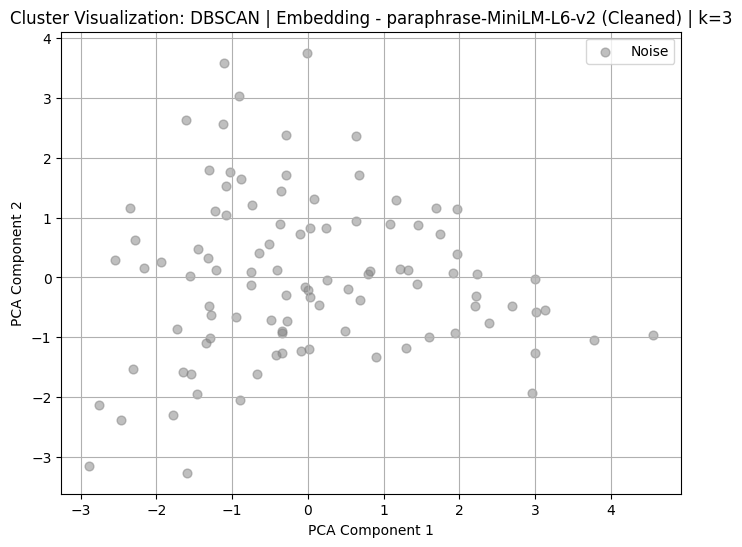


== DBSCAN | Embedding - paraphrase-MiniLM-L6-v2 (Cleaned) | Clusters = 5 ==


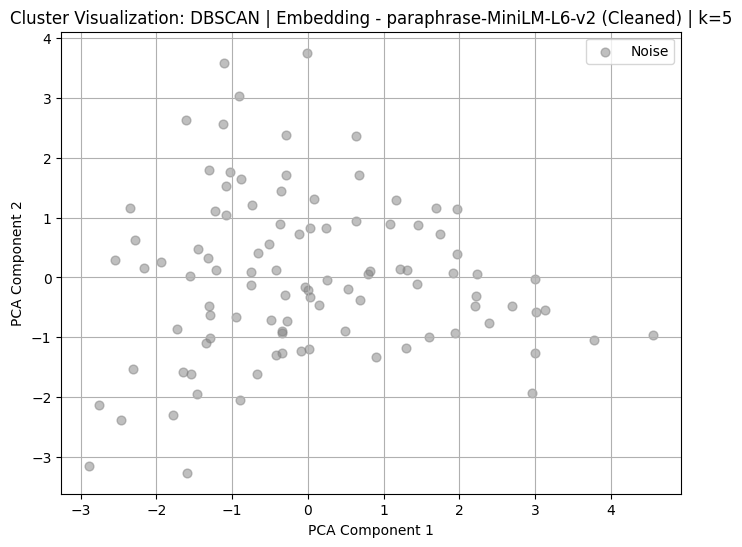


== DBSCAN | Embedding - paraphrase-MiniLM-L6-v2 (Cleaned) | Clusters = 7 ==


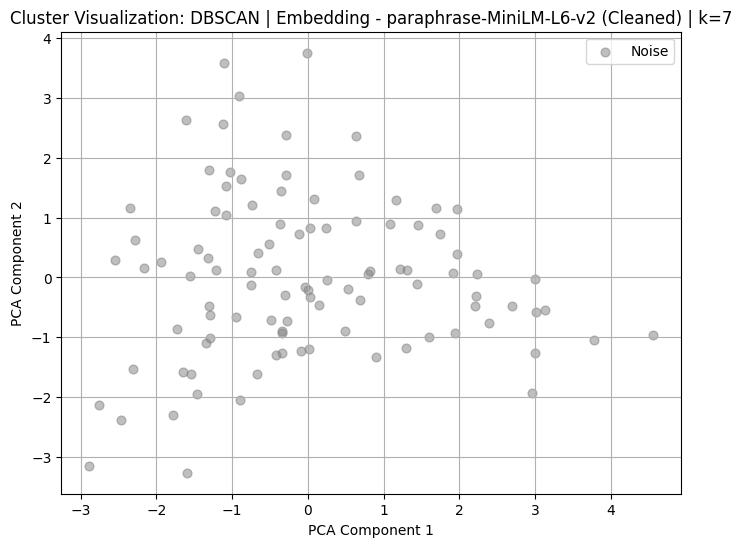


--- Clustering for Embedding - paraphrase-distilroberta-base-v1 (Cleaned) ---

== KMeans | Embedding - paraphrase-distilroberta-base-v1 (Cleaned) | Clusters = 3 ==

-- Cluster 0 --
> Dear how is chechi. Did you talk to her...
> I can't speak, bcaz mobile have problem. I can listen you but you cann't listen my voice. So i calls...
> Hey mate. Spoke to the mag people. WeÛ÷re on.  the is deliver by the end of the month. Deliver on t...

-- Cluster 1 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150...
> Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me...
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...

-- Cluster 2 

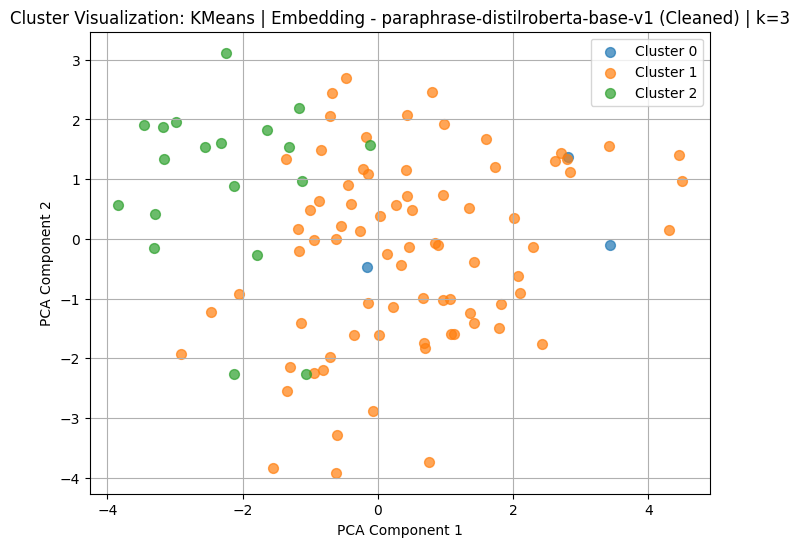


== KMeans | Embedding - paraphrase-distilroberta-base-v1 (Cleaned) | Clusters = 5 ==

-- Cluster 0 --
> Dear how is chechi. Did you talk to her...
> I can't speak, bcaz mobile have problem. I can listen you but you cann't listen my voice. So i calls...
> Hey mate. Spoke to the mag people. WeÛ÷re on.  the is deliver by the end of the month. Deliver on t...

-- Cluster 1 --
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150...
> Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me...
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...
> Get down in gandhipuram and walk to cross cut road. Right side &lt;#&gt; street road and turn at fir...

-- Cluster 2 --
> K.i did't see you.:)k:)where are you now?...
> When can Ì_ come out?...
> 

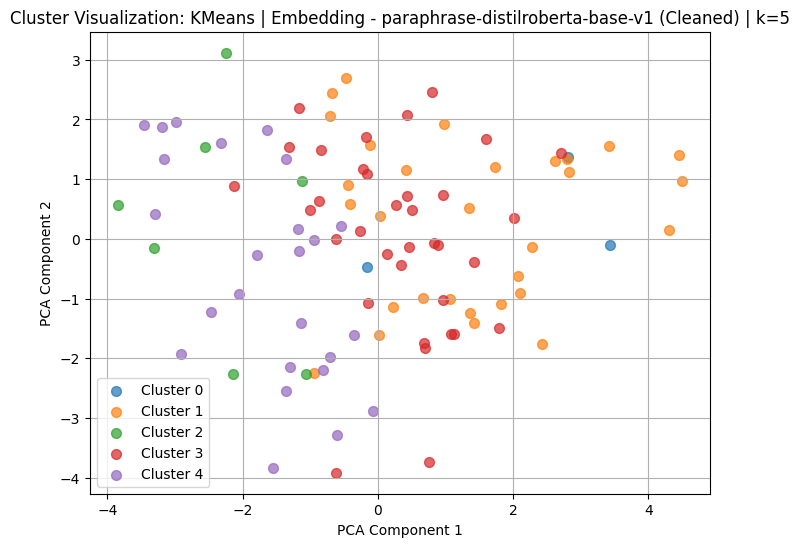


== KMeans | Embedding - paraphrase-distilroberta-base-v1 (Cleaned) | Clusters = 7 ==

-- Cluster 0 --
> Dear how is chechi. Did you talk to her...
> I can't speak, bcaz mobile have problem. I can listen you but you cann't listen my voice. So i calls...
> Hey mate. Spoke to the mag people. WeÛ÷re on.  the is deliver by the end of the month. Deliver on t...

-- Cluster 1 --
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150...
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...
> Get down in gandhipuram and walk to cross cut road. Right side &lt;#&gt; street road and turn at fir...
> I'm wif him now buying tix lar......

-- Cluster 2 --
> K.i did't see you.:)k:)where are you now?...
> Ok thanx... Take care then......
> Okie... Thanx......

-- Cluster 3 --
> Funny fact Nobody te

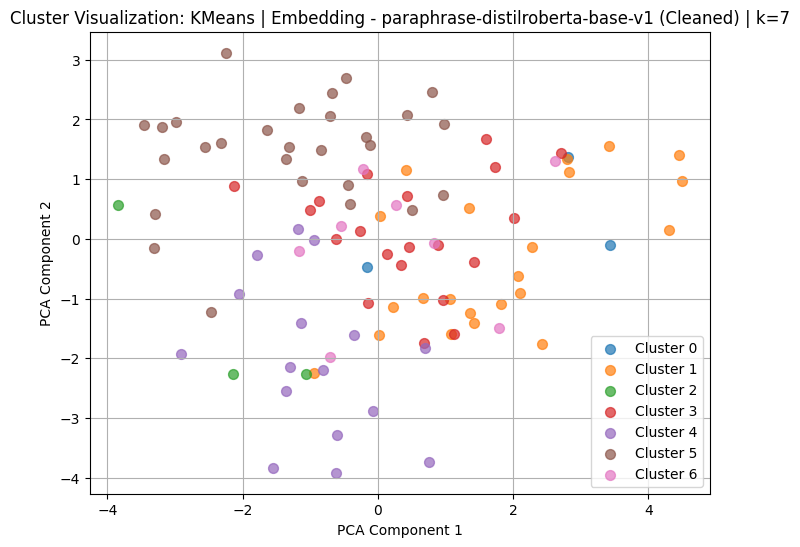


== Agglomerative | Embedding - paraphrase-distilroberta-base-v1 (Cleaned) | Clusters = 3 ==

-- Cluster 0 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150...
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...
> Get down in gandhipuram and walk to cross cut road. Right side &lt;#&gt; street road and turn at fir...

-- Cluster 1 --
> I'll text carlos and let you know, hang on...
> K.i did't see you.:)k:)where are you now?...
> No message..no responce..what happend?...
> You flippin your shit yet?...
> For real tho this sucks. I can't even cook my whole electricity is out. And I'm hungry....

-- Cluster 2 --
> Only if you promise your getting out as SOON as you can. And

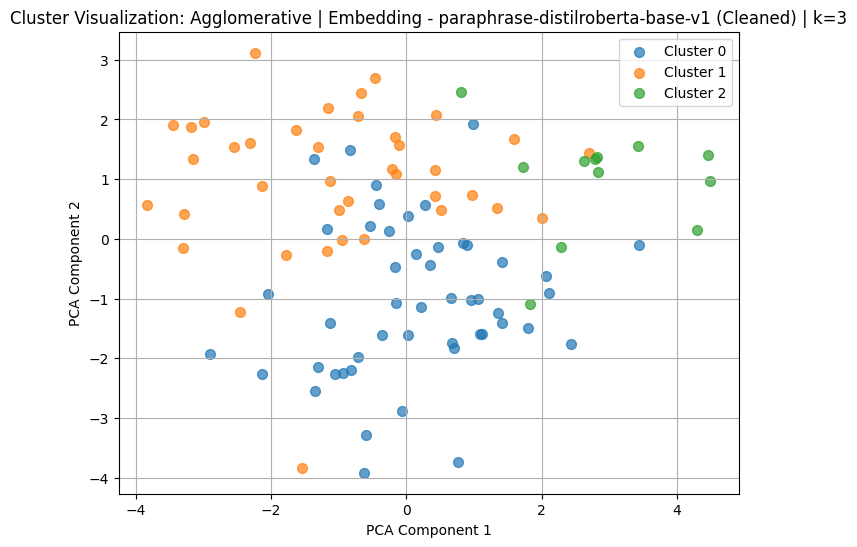


== Agglomerative | Embedding - paraphrase-distilroberta-base-v1 (Cleaned) | Clusters = 5 ==

-- Cluster 0 --
> K.i did't see you.:)k:)where are you now?...
> When can Ì_ come out?...
> Wat Ì_ doing now?...
> Yeah it's jus rite......
> I know you mood off today...

-- Cluster 1 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...
> Get down in gandhipuram and walk to cross cut road. Right side &lt;#&gt; street road and turn at fir...
> Call me when u finish then i come n pick u....

-- Cluster 2 --
> Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me...
> URGENT! Your mobile was awarded a å£1,500 Bonus Caller Prize on 27/6/03. Our final attempt 2 contact...
> This is the 2n

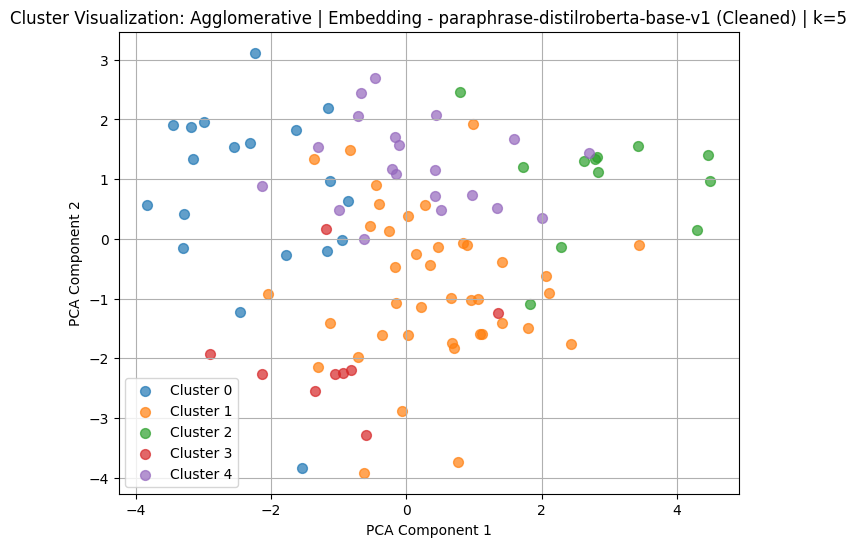


== Agglomerative | Embedding - paraphrase-distilroberta-base-v1 (Cleaned) | Clusters = 7 ==

-- Cluster 0 --
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...
> Dear how is chechi. Did you talk to her...
> Boy; I love u Grl: Hogolo Boy: gold chain kodstini Grl: Agalla Boy: necklace madstini Grl: agalla Bo...
> No it was cancelled yeah baby! Well that sounds important so i understand my darlin give me a ring l...

-- Cluster 1 --
> I'll text carlos and let you know, hang on...
> No message..no responce..what happend?...
> You flippin your shit yet?...
> For real tho this sucks. I can't even cook my whole electricity is out. And I'm hungry....
> Free tones Hope you enjoyed your new content. text stop to 61610 to unsubscribe. help:08712400602450...

-- Cluster 2 --
> Only if you promise your getting out as SOON as you can. And y

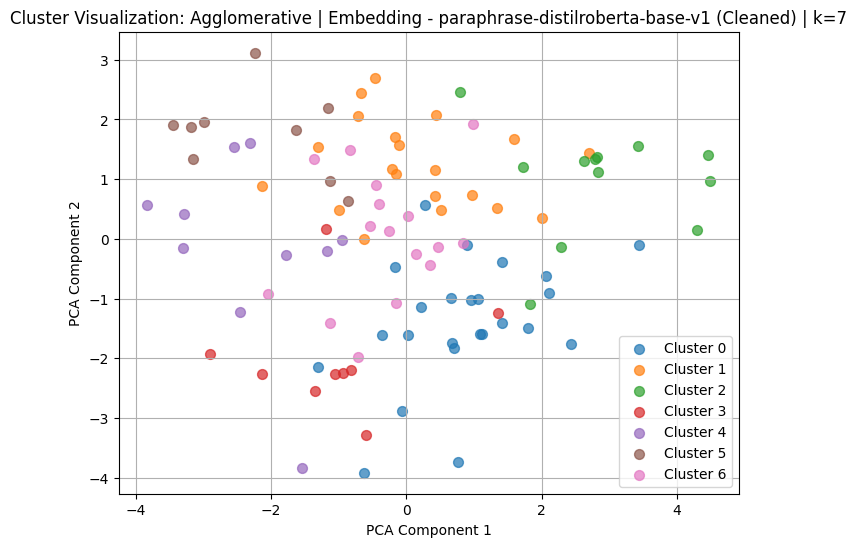


== GMM | Embedding - paraphrase-distilroberta-base-v1 (Cleaned) | Clusters = 3 ==

-- Cluster 0 --
> Dear how is chechi. Did you talk to her...
> I can't speak, bcaz mobile have problem. I can listen you but you cann't listen my voice. So i calls...
> Hey mate. Spoke to the mag people. WeÛ÷re on.  the is deliver by the end of the month. Deliver on t...

-- Cluster 1 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150...
> Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me...
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...

-- Cluster 2 --
> K.i did't see you.:)k:)where are you now?...
> You flippin your shit yet?...


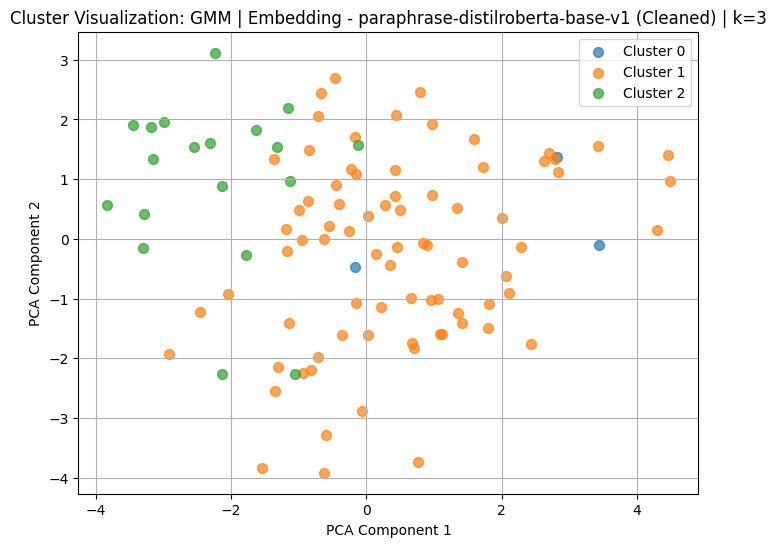


== GMM | Embedding - paraphrase-distilroberta-base-v1 (Cleaned) | Clusters = 5 ==

-- Cluster 0 --
> Dear how is chechi. Did you talk to her...
> I can't speak, bcaz mobile have problem. I can listen you but you cann't listen my voice. So i calls...
> Hey mate. Spoke to the mag people. WeÛ÷re on.  the is deliver by the end of the month. Deliver on t...

-- Cluster 1 --
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150...
> Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me...
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...
> Get down in gandhipuram and walk to cross cut road. Right side &lt;#&gt; street road and turn at fir...

-- Cluster 2 --
> K.i did't see you.:)k:)where are you now?...
> When can Ì_ come out?...
> You

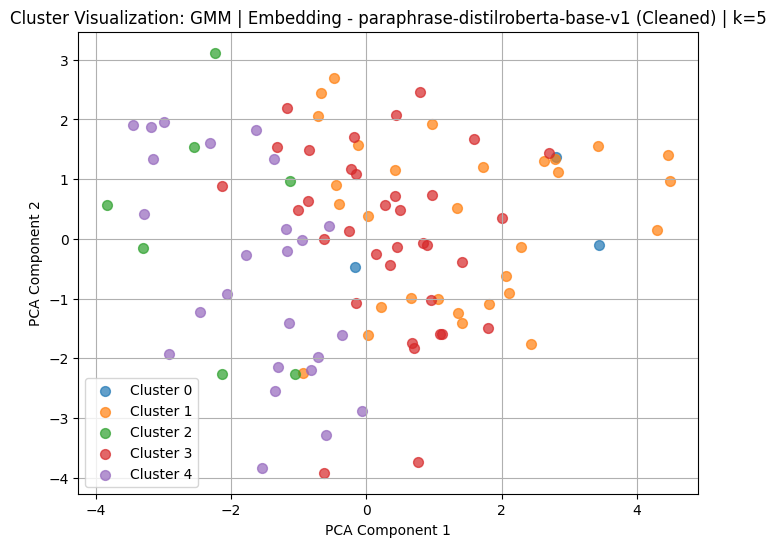


== GMM | Embedding - paraphrase-distilroberta-base-v1 (Cleaned) | Clusters = 7 ==

-- Cluster 0 --
> Dear how is chechi. Did you talk to her...
> I can't speak, bcaz mobile have problem. I can listen you but you cann't listen my voice. So i calls...
> Hey mate. Spoke to the mag people. WeÛ÷re on.  the is deliver by the end of the month. Deliver on t...

-- Cluster 1 --
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150...
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...
> Get down in gandhipuram and walk to cross cut road. Right side &lt;#&gt; street road and turn at fir...
> I'm wif him now buying tix lar......

-- Cluster 2 --
> K.i did't see you.:)k:)where are you now?...
> Ok thanx... Take care then......
> Okie... Thanx......

-- Cluster 3 --
> Funny fact Nobody teach

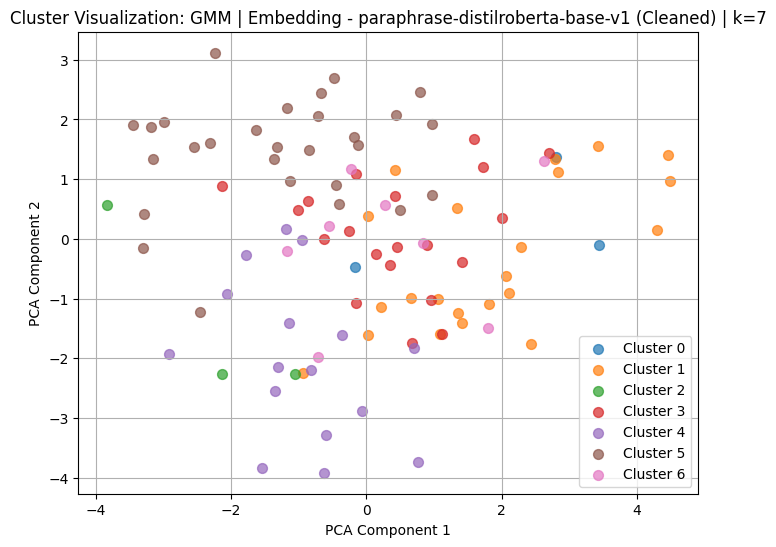


== Spectral | Embedding - paraphrase-distilroberta-base-v1 (Cleaned) | Clusters = 3 ==

-- Cluster 0 --
> I sent my scores to sophas and i had to do secondary application for a few schools. I think if you a...
> We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150...
> Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me...
> Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt...
> I'll text carlos and let you know, hang on...

-- Cluster 1 --
> Can Ì_ call me at 10:10 to make sure dat i've woken up......
> Boy; I love u Grl: Hogolo Boy: gold chain kodstini Grl: Agalla Boy: necklace madstini Grl: agalla Bo...
> No it was cancelled yeah baby! Well that sounds important so i understand my darlin give me a ring l...
> Gud gud..k, chikku tke care.. sleep well gud nyt...
> Alrite jod hows the revision goin? Keris bin doin a smidgin. N e way u wann

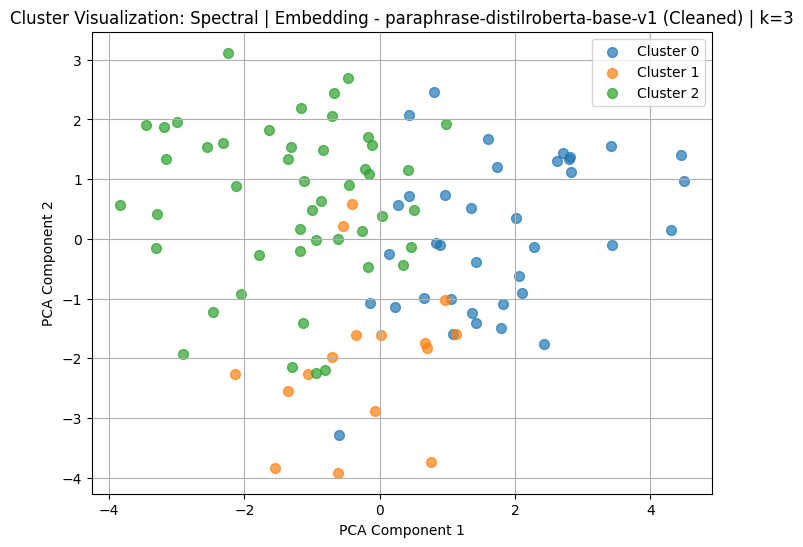


== Spectral | Embedding - paraphrase-distilroberta-base-v1 (Cleaned) | Clusters = 5 ==

-- Cluster 0 --
> Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teache...
> You flippin your shit yet?...
> For real tho this sucks. I can't even cook my whole electricity is out. And I'm hungry....
> Dear how is chechi. Did you talk to her...
> K, if u bored up just come to my home.....

-- Cluster 1 --
> K.i did't see you.:)k:)where are you now?...
> When can Ì_ come out?...
> Wat Ì_ doing now?...
> I know you mood off today...
> You'd like that wouldn't you? Jerk!...

-- Cluster 2 --
> We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150...
> Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me...
> I'll text carlos and let you know, hang on...
> No message..no responce..what happend?...
> Free tones Hope you enjoyed your new content. text stop to 61610 

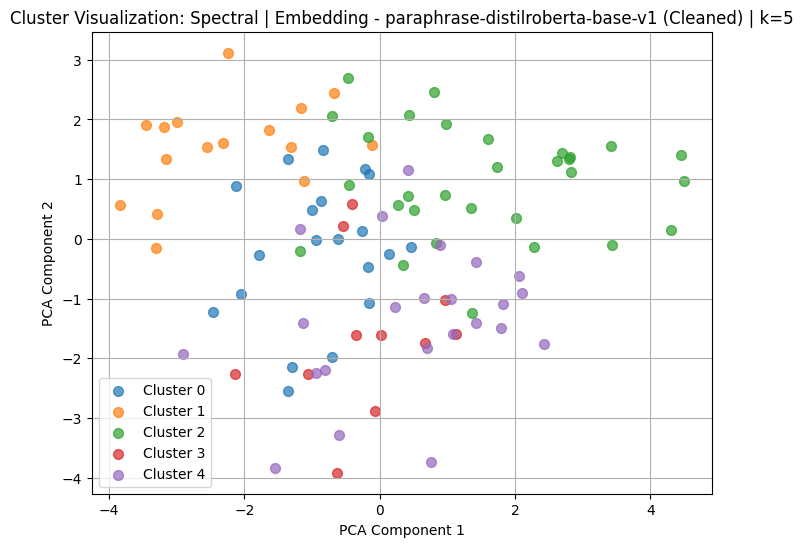


== Spectral | Embedding - paraphrase-distilroberta-base-v1 (Cleaned) | Clusters = 7 ==

-- Cluster 0 --
> Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me...
> I'll text carlos and let you know, hang on...
> No message..no responce..what happend?...
> Free tones Hope you enjoyed your new content. text stop to 61610 to unsubscribe. help:08712400602450...
> What's up. Do you want me to come online?...

-- Cluster 1 --
> K.i did't see you.:)k:)where are you now?...
> For real tho this sucks. I can't even cook my whole electricity is out. And I'm hungry....
> When can Ì_ come out?...
> Its not the same here. Still looking for a job. How much do Ta's earn there....
> LOL that would be awesome payback....

-- Cluster 2 --
> Can Ì_ call me at 10:10 to make sure dat i've woken up......
> Gud gud..k, chikku tke care.. sleep well gud nyt...
> I know girls always safe and selfish know i got it pa. Thank you. good night....
> Daddy will take goo

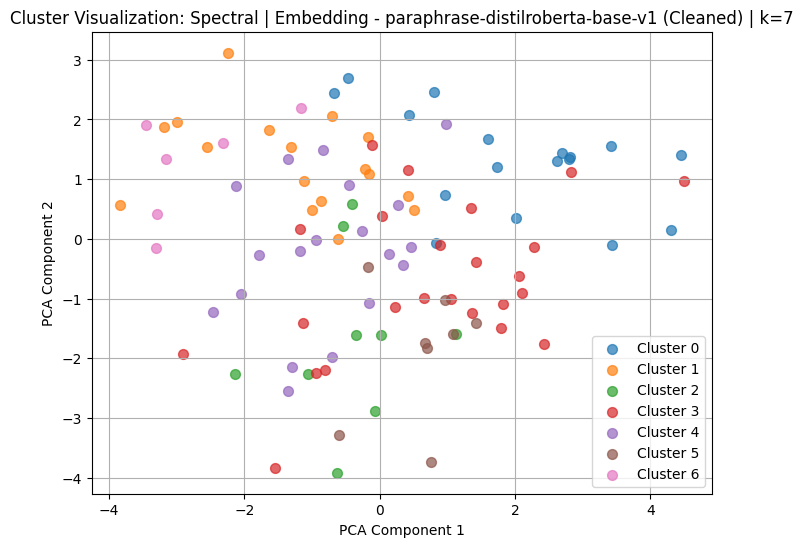


== DBSCAN | Embedding - paraphrase-distilroberta-base-v1 (Cleaned) | Clusters = 3 ==


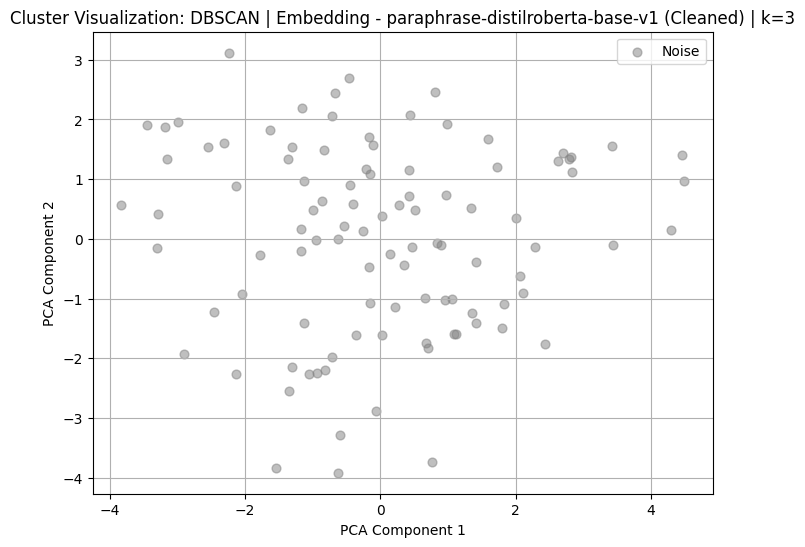


== DBSCAN | Embedding - paraphrase-distilroberta-base-v1 (Cleaned) | Clusters = 5 ==


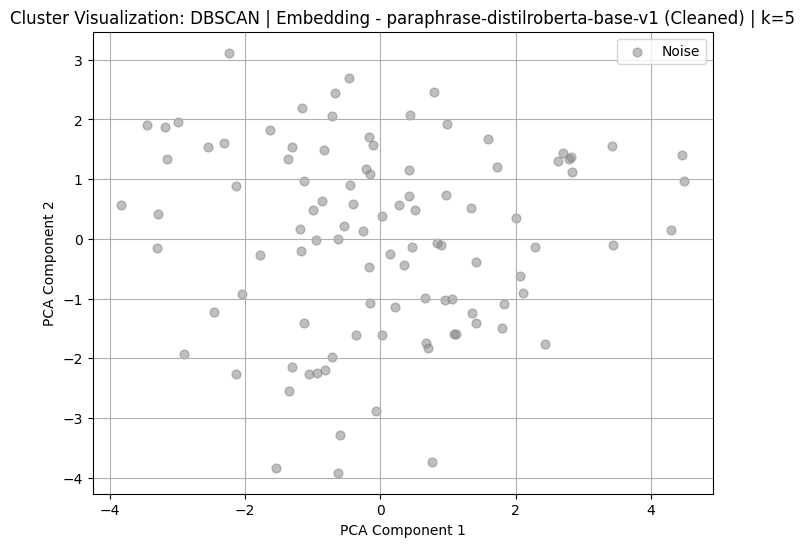


== DBSCAN | Embedding - paraphrase-distilroberta-base-v1 (Cleaned) | Clusters = 7 ==


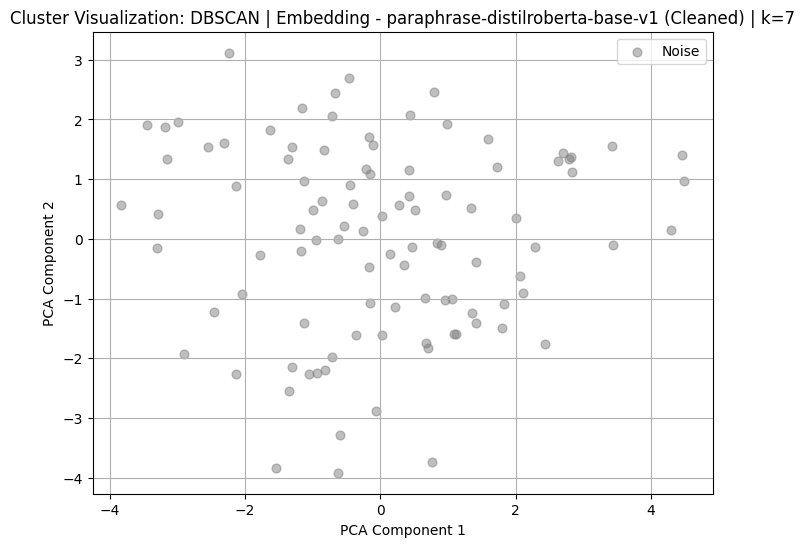

In [ ]:
# ====================== RUN CLUSTERING ON CLEANED TEXT ======================

# Cluster on full BoW matrix from cleaned text
cluster_and_interpret(bow_matrix, "BoW_Cleaned", original_texts_for_clustering)

# Cluster on full TF-IDF matrix from cleaned text
cluster_and_interpret(tfidf_matrix, "TFIDF_Cleaned", original_texts_for_clustering)

# Cluster on sentence embeddings (already derived from cleaned text)
for model_name, embedding in sentence_embeddings.items():
    cluster_and_interpret(embedding, f"Embedding - {model_name} (Cleaned)", original_texts_for_clustering)


In [ ]:
# Take only the first 100 cleaned texts
sampled_texts = df['cleaned_text'].head(100)

# Recreate BoW from 100 rows
bow_vectorizer_sampled = CountVectorizer()
bow_matrix_sampled = bow_vectorizer_sampled.fit_transform(sampled_texts)
feature_names = bow_vectorizer_sampled.get_feature_names_out()

# -------- Helper: Auto Theme Detector ----------
def guess_topic_theme(top_words):
    keywords = {
        "love": "Relationships",
        "boy": "Relationships",
        "grl": "Relationships",
        "call": "Communication",
        "text": "Texting",
        "claim": "Marketing / Offers",
        "prize": "Marketing / Offers",
        "hmv": "Promotions",
        "free": "Offers / Ads",
        "gud": "Friendship",
        "care": "Emotional / Support",
        "school": "Education / Youth",
        "game": "Games / Fun",
        "voucher": "Coupons / Offers",
        "god": "Religious / Spiritual",
        "road": "Travel / Directions",
        "lunch": "Food / Social",
        "wife": "Family / Personal Life",
        "chat": "Messaging",
        "wat": "Casual Talk",
        "think": "Opinion / Thought",
        "meeting": "Work / Plans",
        "home": "Daily Life"
    }
    for word in top_words:
        for keyword, theme in keywords.items():
            if keyword in word:
                return theme
    return "General Conversation"

# -------- Function: Print and Interpret Topics ----------
def print_and_interpret_lda_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\n===== Topic {topic_idx + 1} =====")
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"Top Words: {', '.join(top_words)}")
        theme = guess_topic_theme(top_words)
        print(f"Suggested Theme: {theme}")

# -------- Main Loop: Try Different Topic Counts ----------
num_topics_options = [5, 7, 10]

for n_topics in num_topics_options:
    print(f"\n\n===== Running LDA with {n_topics} Topics =====")
    lda_model = LatentDirichletAllocation(n_components=n_topics,
                                          max_iter=10,
                                          learning_method='batch',
                                          random_state=42,
                                          n_jobs=-1)
    lda_model.fit(bow_matrix_sampled)

    # Print top words and guessed themes
    print_and_interpret_lda_topics(lda_model, feature_names, n_top_words=10)

    # Print dominant topics for first 10 documents
    print("\nTop 2 dominant topics for first 10 documents (for this model):")
    doc_topic_dist = lda_model.transform(bow_matrix_sampled)
    for i in range(min(10, doc_topic_dist.shape[0])):
        distribution = doc_topic_dist[i]
        top_indices = distribution.argsort()[::-1][:2]
        desc = []
        for idx in top_indices:
            percent = round(distribution[idx] * 100, 2)
            desc.append(f"{percent}% Topic_{idx + 1}")
        print(f"Document {i+1}: " + ", ".join(desc))

print("\n====================== LDA Topic Modeling Complete ======================")



===== Running LDA with 5 Topics =====

===== Topic 1 =====
Top Words: text, bloo, come, said, ca, wan, give, yeah, god, sue
Suggested Theme: Texting

===== Topic 2 =====
Top Words: call, one, claim, contact, prize, see, would, wish, said, ok
Suggested Theme: Communication

===== Topic 3 =====
Top Words: later, gud, like, love, call, lt, gt, want, come, think
Suggested Theme: Friendship

===== Topic 4 =====
Top Words: know, call, free, need, text, hmv, reply, finish, mobile, na
Suggested Theme: Communication

===== Topic 5 =====
Top Words: know, boy, grl, love, care, take, ur, go, ok, someone
Suggested Theme: Relationships

Top 2 dominant topics for first 10 documents (for this model):
Document 1: 95.79% Topic_5, 1.06% Topic_2
Document 2: 96.18% Topic_2, 0.96% Topic_3
Document 3: 89.84% Topic_5, 2.58% Topic_4
Document 4: 91.93% Topic_4, 2.03% Topic_5
Document 5: 94.64% Topic_5, 1.35% Topic_4
Document 6: 86.43% Topic_5, 3.46% Topic_4
Document 7: 59.77% Topic_2, 10.12% Topic_4
Document 